# 2 —Å–æ—Ä–µ–≤–Ω–æ–≤–∞–Ω–∏–µ: –ú—É–ª—å—Ç–∏–ª–µ–π–±–ª –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è

## –ò–º–ø–æ—Ä—Ç—ã –±–∏–±–ª–∏–æ—Ç–µ–∫ –∏ –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –≥–ª–æ–∞–±–ª—å–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import emoji
from tqdm.notebook import tqdm
import copy
import math
import json
import functools
import random
import shutil

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

import gensim
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import gc

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, AutoModel
from transformers import TrainingArguments
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset as HFDataset

from scipy.optimize import minimize

DATA_PATH = './'  # –ü—É—Ç—å –∫ –¥–∞–Ω–Ω—ã–º
MODEL_SAVE_DIR = "./trained_models" # –û–±—â–∞—è –ø–∞–ø–∫–∞ –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
SEED = 42

# –û–±—â–∏–µ –¥–ª—è –º–Ω–æ–≥–∏—Ö –º–æ–¥–µ–ª–µ–π
MAX_LEN = 300                   # –ú–∞–∫—Å. –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –¥–ª—è RNN/CNN
BATCH_SIZE = 64                 # –û–±—â–∏–π –±–∞—Ç—á –¥–ª—è –Ω–µ-BERT –º–æ–¥–µ–ª–µ–π
EARLY_STOPPING_PATIENCE = 3
TEST_SPLIT_SIZE = 0.2           # –†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏
MAX_POS_WEIGHT = 20.0           # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –¥–ª—è pos_weight

# –°–ª–æ–≤–∞—Ä–∏ –∏ –ø–∞–¥–¥–∏–Ω–≥ (–¥–ª—è –º–æ–¥–µ–ª–µ–π –Ω–∞ –æ—Å–Ω–æ–≤–µ —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ —Å–ª–æ–≤)
PAD_IDX = 0
UNK_IDX = 1


# 4.1 TF-IDF + MLP
HIDDEN_DIM_MLP = 256

# 4.2 Word2Vec + LSTM
W2V_VECTOR_SIZE = 300
W2V_WINDOW = 5
W2V_MIN_COUNT = 3
W2V_WORKERS = 0
W2V_EPOCHS = 10
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 1
LSTM_BIDIRECTIONAL = True
LSTM_DROPOUT = 0.4
FREEZE_EMBEDDINGS = False

# 4.3 CNN + Trainable Embeddings
CNN_EMBEDDING_DIM = 200
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
CNN_DROPOUT = 0.5

# 4.4 RNN (LSTM) + Trainable Embeddings
RNN_TE_EMBEDDING_DIM = 200
RNN_TE_HIDDEN_DIM = 128
RNN_TE_LAYERS = 1
RNN_TE_BIDIRECTIONAL = True
RNN_TE_DROPOUT = 0.4

# 4.5 BERT-tiny (cointegrated/rubert-tiny2)
MODEL_NAME_BERT_TINY = "cointegrated/rubert-tiny2"
BERT_MAX_LEN = 512
BERT_TINY_BATCH_SIZE = 16
BERT_TINY_EPOCHS = 5
BERT_TINY_LR = 2e-5
OUTPUT_DIR_BERT_TINY = "./bert_tiny_training_output"

# 4.6.1 BERTA (–≤–µ—Ä—Å–∏—è 1 - –Ω–∞–ø—Ä–∏–º–µ—Ä, len 256, –±–µ–∑ –≤–µ—Å–æ–≤)
MODEL_NAME_BERTA_V1 = "sergeyzh/BERTA" 
BERTA_V1_MAX_LEN = 256
BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE = 1
BERTA_V1_EFFECTIVE_BATCH_SIZE = 8
BERTA_V1_GRAD_ACCUM_STEPS = BERTA_V1_EFFECTIVE_BATCH_SIZE // BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE
BERTA_V1_EPOCHS = 3
BERTA_V1_LR = 2e-5
OUTPUT_DIR_BERTA_V1 = "./berta_training_output"

# 4.6.2 BERTA (–≤–µ—Ä—Å–∏—è 2 - len 384, —Å –≤–µ—Å–∞–º–∏)
MODEL_NAME_BERTA_V2 = "sergeyzh/BERTA"
BERTA_V2_MAX_LEN = 384
BERTA_V2_BATCH_SIZE_PER_DEVICE = 2
BERTA_V2_EFFECTIVE_BATCH_SIZE = 4
BERTA_V2_GRAD_ACCUM_STEPS = BERTA_V2_EFFECTIVE_BATCH_SIZE // BERTA_V2_BATCH_SIZE_PER_DEVICE
BERTA_V2_EPOCHS = 3
BERTA_V2_LR = 2e-5
MAX_POS_WEIGHT_BERTA_V2 = 20.0
BERTA_V2_MAX_LEN = 384 
OUTPUT_DIR_BERTA_V2 = "./berta_v2_training_output_mem_opt"

# 4.7 –ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –∏ –º–æ–¥–µ–ª—å W2V+LSTM –Ω–∞ –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
NUM_AUGMENT_SAMPLES = 1000
TEXT_COLUMN_FOR_AUG = 'text_cleaned_sequential'
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è W2V –Ω–∞ –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (–º–æ–≥—É—Ç –±—ã—Ç—å —Ç–µ –∂–µ, —á—Ç–æ –∏ –¥–ª—è –æ–±—ã—á–Ω–æ–≥–æ W2V)
W2V_VECTOR_SIZE_AUG = 300
W2V_WINDOW_AUG = 5
W2V_MIN_COUNT_AUG = 3
W2V_WORKERS_AUG = 0
W2V_EPOCHS_AUG = 10
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è LSTM –Ω–∞ –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
LSTM_HIDDEN_DIM_AUG = 128
LSTM_LAYERS_AUG = 1
LSTM_BIDIRECTIONAL_AUG = True
LSTM_DROPOUT_AUG = 0.4
FREEZE_EMBEDDINGS_W2V_LSTM_AUG = False
PAD_IDX_AUG = PAD_IDX
UNK_IDX_AUG = UNK_IDX
VOCAB_SIZE_AUG = None

# 4.8 –ì–∏–±—Ä–∏–¥–Ω–∞—è –º–æ–¥–µ–ª—å
BERT_MODEL_NAME_FOR_HYBRID_FEATURES = "cointegrated/rubert-base-cased-nli-threeway"
BERT_MAX_LEN_HYBRID_FEATURES = 256
HYBRID_MLP_HIDDEN_DIM = 512
BERT_FEATURE_EXTRACTOR_BATCH_SIZE = 8

TEST_BATCH_SIZE_ENSEMBLE = 128
NUM_WORKERS_ENSEMBLE_TEST = 0

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

MODEL_PATHS = {
    "tfidf_mlp": os.path.join(MODEL_SAVE_DIR, "tfidf_nn_best_model.pth"),
    "w2v_lstm": os.path.join(MODEL_SAVE_DIR, "w2v_lstm_best_model.pth"),
    "cnn_emb": os.path.join(MODEL_SAVE_DIR, "cnn_emb_best_model.pth"),
    "rnn_emb": os.path.join(MODEL_SAVE_DIR, "rnn_trainable_emb_best_model.pth"), # –≠—Ç–æ LSTM —Å trainable emb
    "bert_tiny": os.path.join(MODEL_SAVE_DIR, "bert_tiny_final_model"),
    "w2v_lstm_augmented": os.path.join(MODEL_SAVE_DIR, "w2v_lstm_augmented_best_model.pth"),
    "hybrid_tfidf_bert_mlp": os.path.join(MODEL_SAVE_DIR, "hybrid_tfidf_bert_mlp_best_model.pth"),
    "berta_classifier_v1": os.path.join(MODEL_SAVE_DIR, "berta_v1_final_model"), 
    "berta_classifier_v2": os.path.join(MODEL_SAVE_DIR, "berta_classifier_v2_len512_weighted_final_model") 
}

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ nltk –∏ pymorphy2
morph = pymorphy2.MorphAnalyzer()
try:
    russian_stop_words = stopwords.words("russian")
except LookupError:
    print("–ó–∞–≥—Ä—É–∑–∫–∞ —Å—Ç–æ–ø-—Å–ª–æ–≤ NLTK –¥–ª—è —Ä—É—Å—Å–∫–æ–≥–æ —è–∑—ã–∫–∞...")
    nltk.download('stopwords')
    russian_stop_words = stopwords.words("russian")
# –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –∫–∞—Å—Ç–æ–º–Ω—ã—Ö —Å—Ç–æ–ø-—Å–ª–æ–≤
custom_stop_words = ['—ç—Ç–æ', '—Ç–∞–∫–∂–µ', '–∫–æ—Ç–æ—Ä—ã–π', '–≤–µ—Å—å', '—Å–≤–æ–π', '–µ—â—ë', '–Ω–∞–ø—Ä–∏–º–µ—Ä', '–∫–∞–∂–¥—ã–π', '–æ—á–µ–Ω—å', '—Ç.–¥', '—Ç.–ø']
for sw in custom_stop_words:
    if sw not in russian_stop_words:
        russian_stop_words.append(sw)
russian_stop_words = set(russian_stop_words)

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ torch device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è GPU (CUDA)")
    torch.cuda.manual_seed_all(SEED)
elif torch.backends.mps.is_available():
     device = torch.device("mps")
     print("–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è GPU (MPS) –Ω–∞ Apple Silicon")
else:
    device = torch.device("cpu")
    print("–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è CPU")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏ tqdm
tqdm.pandas()
sns.set(style="whitegrid")

print(f"–£—Å—Ç—Ä–æ–π—Å—Ç–≤–æ —É—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–æ: {device}")
print(f"–ü–∞–ø–∫–∞ –¥–ª—è –º–æ–¥–µ–ª–µ–π: {MODEL_SAVE_DIR}")

–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è GPU (MPS) –Ω–∞ Apple Silicon
–£—Å—Ç—Ä–æ–π—Å—Ç–≤–æ —É—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–æ: mps
–ü–∞–ø–∫–∞ –¥–ª—è –º–æ–¥–µ–ª–µ–π: ./trained_models


## –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –∞–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö

Train: (29568, 3)
Test: (7392, 2)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥—É–±–ª–∏—Ä—É—é—â–∏—Ö—Å—è —Ç–µ–∫—Å—Ç–æ–≤ –≤ Train: 2601
–†–∞–∑–º–µ—Ä Train –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 29568
–†–∞–∑–º–µ—Ä Train –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 26967

3. –ê–Ω–∞–ª–∏–∑ —Ü–µ–ª–µ–≤—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö (labels)...
–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –ª–µ–π–±–ª–æ–≤: 20


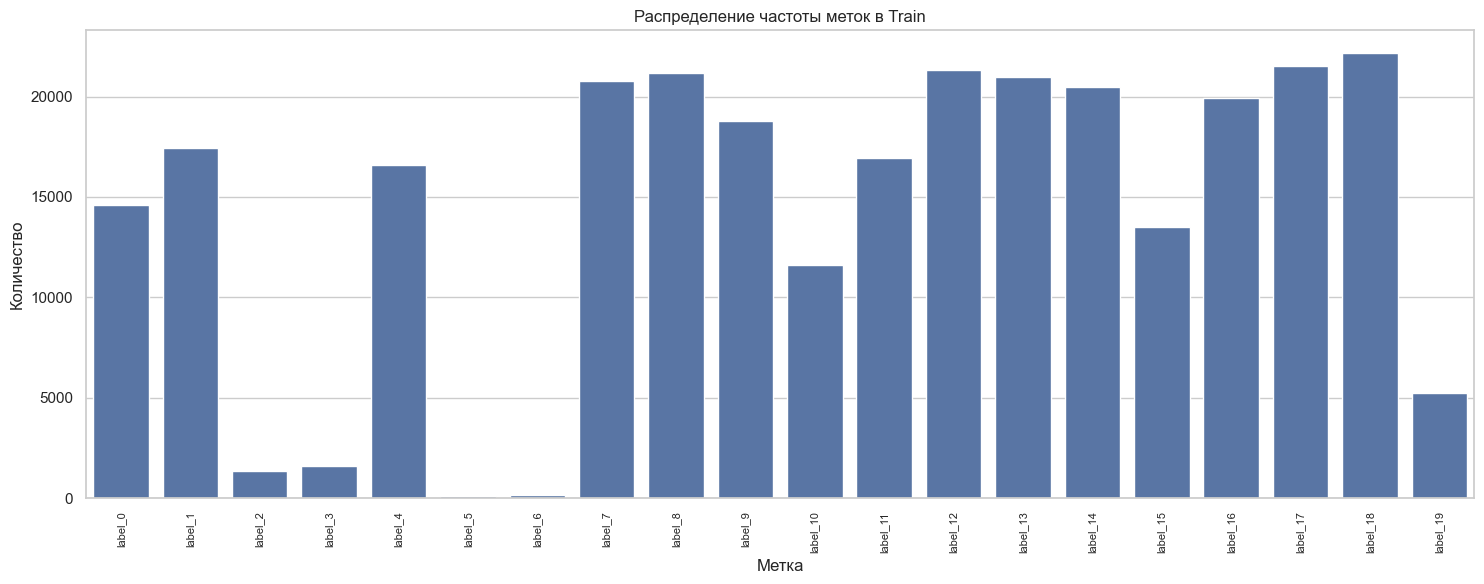

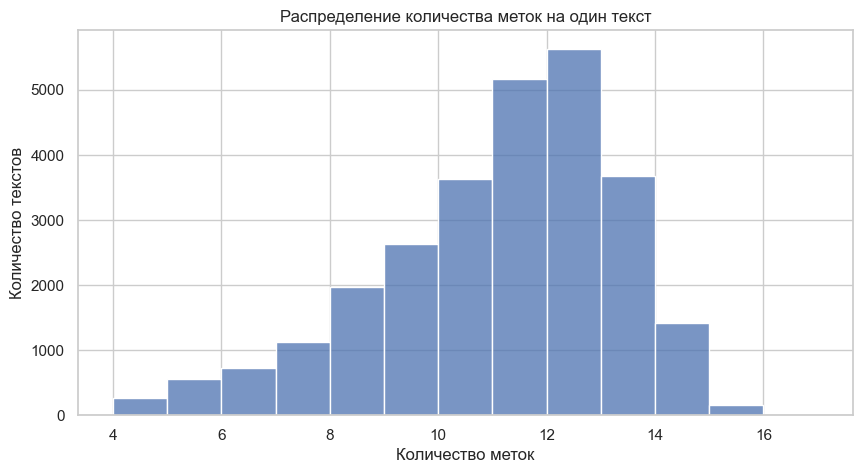

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–∫—Å—Ç–æ–≤ –±–µ–∑ –º–µ—Ç–æ–∫: 0


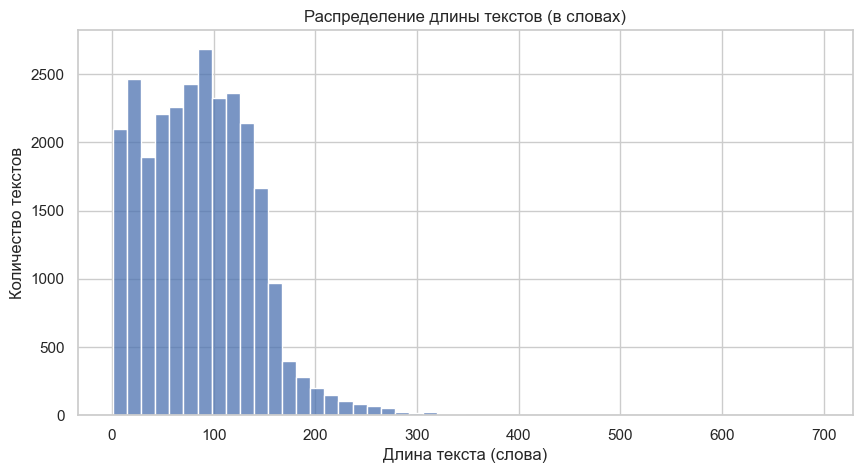

–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ (—Å–ª–æ–≤–∞): 87.04
–ú–µ–¥–∏–∞–Ω–Ω–∞—è –¥–ª–∏–Ω–∞ (—Å–ª–æ–≤–∞): 85.00


In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ –∏ —É–¥–∞–ª–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ —Ç–µ–∫—Å—Ç–∞
duplicate_texts = train_df['text'].duplicated().sum()
print(f"\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥—É–±–ª–∏—Ä—É—é—â–∏—Ö—Å—è —Ç–µ–∫—Å—Ç–æ–≤ –≤ Train: {duplicate_texts}")
if duplicate_texts > 0:
    initial_size = len(train_df)
    train_df = train_df.drop_duplicates(subset=['text']).reset_index(drop=True)
    print(f"–†–∞–∑–º–µ—Ä Train –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {initial_size}")
    print(f"–†–∞–∑–º–µ—Ä Train –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {len(train_df)}")

print("\n3. –ê–Ω–∞–ª–∏–∑ —Ü–µ–ª–µ–≤—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö (labels)...")
train_df['label_list'] = train_df['labels'].apply(lambda x: [int(i) for i in x.split()])
OUTPUT_DIM = len(train_df['label_list'].iloc[0])
print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –ª–µ–π–±–ª–æ–≤: {OUTPUT_DIM}")
y_train = np.array(train_df['label_list'].tolist())

# –ë–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤
label_counts = y_train.sum(axis=0)
label_names = np.array([f'label_{i}' for i in range(OUTPUT_DIM)])
plt.figure(figsize=(15, 6))
sns.barplot(x=label_names, y=label_counts)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —á–∞—Å—Ç–æ—Ç—ã –º–µ—Ç–æ–∫ –≤ Train')
plt.xlabel('–ú–µ—Ç–∫–∞')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
plt.xticks(rotation=90, fontsize=8); plt.tight_layout(); plt.show()

# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–µ—Ç–æ–∫ –Ω–∞ —Ç–µ–∫—Å—Ç
labels_per_text = y_train.sum(axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(x=labels_per_text, bins=range(labels_per_text.min(), labels_per_text.max() + 2))
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –º–µ—Ç–æ–∫ –Ω–∞ –æ–¥–∏–Ω —Ç–µ–∫—Å—Ç'); plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–µ—Ç–æ–∫'); plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–∫—Å—Ç–æ–≤'); plt.show()
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–∫—Å—Ç–æ–≤ –±–µ–∑ –º–µ—Ç–æ–∫: {(labels_per_text == 0).sum()}")

train_df['text_len_words'] = train_df['text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='text_len_words', bins=50)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–ª–∏–Ω—ã —Ç–µ–∫—Å—Ç–æ–≤ (–≤ —Å–ª–æ–≤–∞—Ö)'); plt.xlabel('–î–ª–∏–Ω–∞ —Ç–µ–∫—Å—Ç–∞ (—Å–ª–æ–≤–∞)'); plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–∫—Å—Ç–æ–≤'); plt.show()
print(f"–°—Ä–µ–¥–Ω—è—è –¥–ª–∏–Ω–∞ (—Å–ª–æ–≤–∞): {train_df['text_len_words'].mean():.2f}")
print(f"–ú–µ–¥–∏–∞–Ω–Ω–∞—è –¥–ª–∏–Ω–∞ (—Å–ª–æ–≤–∞): {train_df['text_len_words'].median():.2f}")

–ï—Å—Ç—å –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤, –º–∞–∫—Å–∏–º–∞–ª—å–Ω—É—é –¥–ª–∏–Ω–Ω—É –º–æ–∂–Ω–æ —Å—Ç–∞–≤–∏—Ç—å 200-300, –æ–¥–∏–Ω –æ–±—ä–µ–∫—Ç –º–æ–∂–µ—Ç –æ—Ç–Ω–æ—Å–∏—Ç—å—Å—è –∫ 10 –∫–ª–∞—Å—Å–∞–º, —É–¥–∞–ª–∏–ª –¥—É–±–ª–∏–∫–∞—Ç—ã –≤ —Ç—Ä–µ–π–Ω–µ, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥–ª–∏ –∑–∞–≤—ã—à–∞—Ç—å —Å–∫–æ—Ä –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –∏ –ø—Ä–∏–≤–æ–¥–∏—Ç—å –∫ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—é –º–æ–¥–µ–ª–∏

## –û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞

In [3]:
def clean_text_for_tfidf(text, stop_words_set):
    """–û—á–∏—Å—Ç–∫–∞ –∏ –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞ –¥–ª—è TF-IDF."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.replace('—ë', '–µ')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    translator = str.maketrans('', '', string.punctuation + '¬´¬ª‚Äú‚Äù‚Äû‚Ä¶‚îÅ')
    text = text.translate(translator)
    text = re.sub(r'\d+', ' ', text)

    words = text.split()
    lemmatized_words = []
    for word in words:
        if word and word not in stop_words_set:
            p = morph.parse(word)[0]
            lemma = p.normal_form
            if len(lemma) > 2:
                lemmatized_words.append(lemma)
    return " ".join(lemmatized_words)

def clean_text_for_sequential(text):
    """–û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ –¥–ª—è Sequential –º–æ–¥–µ–ª–µ–π (W2V, RNN, CNN) - –±–µ–∑ –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏–∏."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.replace('—ë', '–µ')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    punct_to_replace_with_space = string.punctuation + '¬´¬ª‚Äú‚Äù‚Äû‚Ä¶‚îÅ'
    translator = str.maketrans(punct_to_replace_with_space, ' ' * len(punct_to_replace_with_space))
    text = text.translate(translator)
    words = text.split()
    cleaned_words = [word for word in words if len(word) > 1 or word.isdigit()]
    return " ".join(cleaned_words)

def clean_text_for_bert(text):
    """–ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ –¥–ª—è BERT."""
    if not isinstance(text, str): return ""
    text = text.replace('—ë', '–µ')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
tqdm.pandas(desc="–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å")

# Train Data
train_df['text_cleaned_tfidf'] = train_df['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
train_df['text_cleaned_sequential'] = train_df['text'].progress_apply(clean_text_for_sequential)
train_df['text_cleaned_bert'] = train_df['text'].progress_apply(clean_text_for_bert)

# Test Data
test_df['text_cleaned_tfidf'] = test_df['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
test_df['text_cleaned_sequential'] = test_df['text'].progress_apply(clean_text_for_sequential)
test_df['text_cleaned_bert'] = test_df['text'].progress_apply(clean_text_for_bert)

print("Train Data")
display(train_df[['text', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert']].head())

print("\nTest Data")
display(test_df[['text', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert']].head())


–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/26967 [00:00<?, ?it/s]

–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/26967 [00:00<?, ?it/s]

–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/26967 [00:00<?, ?it/s]

–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/7392 [00:00<?, ?it/s]

–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/7392 [00:00<?, ?it/s]

–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/7392 [00:00<?, ?it/s]

Train Data


text  \
0  15 —è–Ω–≤–∞—Ä—è\n–î–µ—Ç—Å–∫–∞—è —Ä–∞–∑–≤–ª–µ–∫–∞—Ç–µ–ª—å–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞\n...   
1  13 –∏ 14 –∞–≤–≥—É—Å—Ç–∞\n–í—ã—Ö–æ–¥–Ω—ã–µ –≤ –ú–µ–≥–µ\nhttps://t.me...   
2  –ô–æ–∫–Ω–∞–ø–∞—Ç–æ—Ñ–∞\n–ü–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –¢–µ–∞—Ç—Ä –∏–º. –ú–∞—è–∫–æ–≤—Å–∫–æ–≥–æ\...   
3  –í–ø–µ—Ä–≤—ã–µ –≤ –£—Ñ–µ —Ç–∞–Ω—Ü–µ–≤–∞–ª—å–Ω–∞—è —Ç–µ—Ä–∞–ø–∏—è –≤ –≥—Ä—É–ø–ø–µ —Å ...   
4  üéπ\nGRAND PIANO COMPETITION\nüéπ\n–î—Ä—É–∑—å—è, —Å–µ–≥–æ–¥–Ω—è...   

                                  text_cleaned_tfidf  \
0  —è–Ω–≤–∞—Ä—å –¥–µ—Ç—Å–∫–∏–π —Ä–∞–∑–≤–ª–µ–∫–∞—Ç–µ–ª—å–Ω—ã–π –ø—Ä–æ–≥—Ä–∞–º–º–∞ –±–µ—Å–ø–ª...   
1                       –∞–≤–≥—É—Å—Ç –≤—ã—Ö–æ–¥–Ω–æ–π –º–µ–≥ –º–µ–≥–∞–ø–∞—Ä–∫   
2       –π–æ–∫–Ω–∞–ø–∞—Ç–æ—Ñ –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ç–µ–∞—Ç—Ä –º–∞—è–∫–æ–≤—Å–∫–∏–π –±–∏–ª–µ—Ç   
3  –≤–ø–µ—Ä–≤—ã–µ —É—Ñ–∞ —Ç–∞–Ω—Ü–µ–≤–∞–ª—å–Ω—ã–π —Ç–µ—Ä–∞–ø–∏—è –≥—Ä—É–ø–ø–∞ –ø—Ä–∞–∫—Ç–∏...   
4  grand piano competition –¥—Ä—É–≥ —Å–µ–≥–æ–¥–Ω—è –æ—Ç–∫—Ä—ã—Ç–∏–µ ...   

                             text_cleaned_sequential  \
0  15 —è–Ω–≤–∞—Ä—è –¥–µ—Ç—Å–∫–∞—è —Ä–∞–∑–≤–ª–µ–∫–∞—Ç–µ–ª—å–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ 15...   
1               13 14 –∞–≤–≥—É—Å—Ç–∞ –≤—ã—Ö–æ–¥–Ω—ã–µ –º–µ–≥–µ –º–µ–≥–∞–ø–∞—Ä–∫   
2  –π–æ–∫–Ω–∞–ø–∞—Ç–æ—Ñ–∞ –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ç–µ–∞—Ç—Ä –∏–º –º–∞—è–∫–æ–≤—Å–∫–æ–≥–æ –±–∏...   
3  –≤–ø–µ—Ä–≤—ã–µ —É—Ñ–µ —Ç–∞–Ω—Ü–µ–≤–∞–ª—å–Ω–∞—è —Ç–µ—Ä–∞–ø–∏—è –≥—Ä—É–ø–ø–µ –ø—Ä–∞–∫—Ç–∏...   
4  grand piano competition –¥—Ä—É–∑—å—è —Å–µ–≥–æ–¥–Ω—è –æ—Ç–∫—Ä—ã—Ç–∏...   

                                   text_cleaned_bert  
0  15 —è–Ω–≤–∞—Ä—è –î–µ—Ç—Å–∫–∞—è —Ä–∞–∑–≤–ª–µ–∫–∞—Ç–µ–ª—å–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ 15...  
1           13 –∏ 14 –∞–≤–≥—É—Å—Ç–∞ –í—ã—Ö–æ–¥–Ω—ã–µ –≤ –ú–µ–≥–µ –ú–µ–≥–∞–ø–∞—Ä–∫  
2  –ô–æ–∫–Ω–∞–ø–∞—Ç–æ—Ñ–∞ –ü–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –¢–µ–∞—Ç—Ä –∏–º. –ú–∞—è–∫–æ–≤—Å–∫–æ–≥–æ –ë...  
3  –í–ø–µ—Ä–≤—ã–µ –≤ –£—Ñ–µ —Ç–∞–Ω—Ü–µ–≤–∞–ª—å–Ω–∞—è —Ç–µ—Ä–∞–ø–∏—è –≤ –≥—Ä—É–ø–ø–µ —Å ...  
4  GRAND PIANO COMPETITION –î—Ä—É–∑—å—è, —Å–µ–≥–æ–¥–Ω—è –æ—Ç–∫—Ä—ã—Ç...


Test Data


text  \
0  –≠–ô, –í–õ–Æ–ë–õ–Å–ù–ù–´–ï\n–°–∫–∏–¥–∫–∞ 20% –ø—Ä–æ–º–æ–∫–æ–¥—É SYHOYZ\n–Ω...   
1                                       –ü—Ä—É–¥—ã –ú–æ—Å–∫–≤—ã   
2  ü§™\nü§™\nüëè\nüëè\nüòÑ\nüòÑ\nüëè\nüëè\nüë®‚Äçüë©‚Äçüë¶\n–°–µ–º–µ–π–∫–∞ –ª—ë–≥–∫–æ–≥–æ...   
3  24 –°–ï–ù–¢–Ø–ë–†–Ø\n–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–π —Ñ–µ—Å—Ç–∏–≤–∞–ª—å ¬´–ë–∞—à–∫–∏—Ä–∏—è ...   
4  19-20 –∞–≤–≥—É—Å—Ç–∞\n–î–µ—Ç—Å–∫–∏–π –∫–ª—É–± –≤ –∫–∞—Ñ–µ ¬´–û—Ç–¥—ã—Ö¬ª\n–¢–µ...   

                                  text_cleaned_tfidf  \
0  –≤–ª—é–±–∏—Ç—å —Å–∫–∏–¥–∫–∞ –ø—Ä–æ–º–æ–∫–æ–¥ syhoyz —Å–ø–µ–∫—Ç–∞–∫–ª—å —ë–∂–∏–∫ ...   
1                                        –ø—Ä—É–¥ –º–æ—Å–∫–≤–∞   
2  —Å–µ–º–µ–π–∫–∞ –ª—ë–≥–∫–∏–π –ø–æ–≤–µ–¥–µ–Ω–∏–µ –Ω–µ–æ–∂–∏–¥–∞–Ω–Ω—ã–π –∫–æ–º–µ–¥–∏—è —Ç...   
3  —Å–µ–Ω—Ç—è–±—Ä—å –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–π —Ñ–µ—Å—Ç–∏–≤–∞–ª—å –±–∞—à–∫–∏—Ä–∏—è —Ä—É—Å—å ...   
4  –∞–≤–≥—É—Å—Ç –¥–µ—Ç—Å–∫–∏–π –∫–ª—É–± –∫–∞—Ñ–µ –æ—Ç–¥—ã—Ö —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–π —Ä–∞...   

                             text_cleaned_sequential  \
0  —ç–π –≤–ª—é–±–ª–µ–Ω–Ω—ã–µ —Å–∫–∏–¥–∫–∞ 20 –ø—Ä–æ–º–æ–∫–æ–¥—É syhoyz –Ω–∞ —Å–ø...   
1                                       –ø—Ä—É–¥—ã –º–æ—Å–∫–≤—ã   
2  —Å–µ–º–µ–π–∫–∞ –ª–µ–≥–∫–æ–≥–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è –Ω–µ–æ–∂–∏–¥–∞–Ω–Ω–∞—è –∫–æ–º–µ–¥–∏—è ...   
3  24 —Å–µ–Ω—Ç—è–±—Ä—è –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–π —Ñ–µ—Å—Ç–∏–≤–∞–ª—å –±–∞—à–∫–∏—Ä–∏—è —Ä—É...   
4  19 20 –∞–≤–≥—É—Å—Ç–∞ –¥–µ—Ç—Å–∫–∏–π –∫–ª—É–± –∫–∞—Ñ–µ –æ—Ç–¥—ã—Ö —Ç–µ–º–∞—Ç–∏—á–µ...   

                                   text_cleaned_bert  
0  –≠–ô, –í–õ–Æ–ë–õ–Å–ù–ù–´–ï –°–∫–∏–¥–∫–∞ 20% –ø—Ä–æ–º–æ–∫–æ–¥—É SYHOYZ –Ω–∞ ...  
1                                       –ü—Ä—É–¥—ã –ú–æ—Å–∫–≤—ã  
2  –°–µ–º–µ–π–∫–∞ –ª–µ–≥–∫–æ–≥–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è –ù–µ–æ–∂–∏–¥–∞–Ω–Ω–∞—è –∫–æ–º–µ–¥–∏—è ...  
3  24 –°–ï–ù–¢–Ø–ë–†–Ø –ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–π —Ñ–µ—Å—Ç–∏–≤–∞–ª—å ¬´–ë–∞—à–∫–∏—Ä–∏—è –∏...  
4  19-20 –∞–≤–≥—É—Å—Ç–∞ –î–µ—Ç—Å–∫–∏–π –∫–ª—É–± –≤ –∫–∞—Ñ–µ ¬´–û—Ç–¥—ã—Ö¬ª –¢–µ–º–∞...

## –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [5]:
X_indices = np.arange(len(train_df)).reshape(-1, 1)
X_train_idx_indices, y_train_final, X_val_idx_indices, y_val_split = iterative_train_test_split(
    X_indices, y_train, test_size=TEST_SPLIT_SIZE
)
train_indices = X_train_idx_indices.flatten()
val_indices = X_val_idx_indices.flatten()

train_split_df = train_df.iloc[train_indices].reset_index(drop=True)
val_split_df = train_df.iloc[val_indices].reset_index(drop=True)
y_val_final = y_val_split

print(f"–†–∞–∑–º–µ—Ä –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏ (DF): {train_split_df.shape}")
print(f"–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ (DF): {val_split_df.shape}")
print(f"–†–∞–∑–º–µ—Ä y_train_final: {y_train_final.shape}")
print(f"–†–∞–∑–º–µ—Ä y_val_final: {y_val_final.shape}")


–†–∞–∑–º–µ—Ä –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏ (DF): (21545, 8)
–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ (DF): (5422, 8)
–†–∞–∑–º–µ—Ä y_train_final: (21545, 20)
–†–∞–∑–º–µ—Ä y_val_final: (5422, 20)


## –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã—Ö —Ñ—É–Ω–∫—Ü–∏–π –∏ –∫–ª–∞—Å—Å–æ–≤

In [6]:
# –¥–∞—Ç–∞—Å–µ—Ç—ã
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        if features.shape[0] != labels.shape[0]:
            raise ValueError("Mismatch features/labels")
        self.features = features
        self.labels = labels
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        feat = torch.tensor(self.features[idx].toarray().flatten(), dtype=torch.float32)
        lab = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feat, lab

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_len):
        if len(sequences) != labels.shape[0]:
            raise ValueError("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π –Ω–µ —Å–æ–≤–ø–∞–¥–∞–µ—Ç —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –º–µ—Ç–æ–∫")
        self.sequences = sequences
        self.labels = labels
        self.max_len = max_len
        self.UNK_IDX = 1
        self.PAD_IDX = 0

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx][:self.max_len]
        if not seq:
            seq = [self.UNK_IDX]
        sequence_tensor = torch.tensor(seq, dtype=torch.long)
        label_vector = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence_tensor, label_vector


# –º–æ–¥–µ–ª–∏
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, pretrained_embeddings=None, freeze_embeddings=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout_layer(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout_layer(hidden[-1,:,:])
        return self.fc(hidden)

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, n_filters, fs) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[-1]).squeeze(-1) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        return self.fc(cat)

class LSTMClassifierTrainableEmb(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, 
                            dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout_layer(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) if self.lstm.bidirectional else self.dropout_layer(hidden[-1,:,:])
        return self.fc(hidden)

In [7]:
# –§—É–Ω–∫—Ü–∏—è —Ä–∞—Å—á–µ—Ç–∞ AUC
def calculate_auc(all_targets, all_preds):
    targets_np = all_targets.cpu().numpy()
    preds_np = all_preds.cpu().numpy()
    auc_scores = []
    for i in range(targets_np.shape[1]):
        if len(np.unique(targets_np[:, i])) > 1:
             try:
                 auc = roc_auc_score(targets_np[:, i], preds_np[:, i])
                 auc_scores.append(auc)
             except ValueError:
                  auc_scores.append(0.5)
        else:
             auc_scores.append(0.5)
    return np.mean(auc_scores) if auc_scores else 0.0

# –ó–∞–≥—Ä—É–∑–∫–∞ NLTK —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("–ó–∞–≥—Ä—É–∑–∫–∞ NLTK —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ 'punkt'...")
    nltk.download('punkt')

def compute_metrics(eval_pred):
    logits, labels = eval_pred; preds = 1/(1+np.exp(-logits)); targets = labels.astype(int)
    auc_scores = []
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:, i])) > 1:
            try: auc = roc_auc_score(targets[:, i], preds[:, i]); auc_scores.append(auc)
            except ValueError: auc_scores.append(0.5)
        else: auc_scores.append(0.5)
    return {"roc_auc_macro": np.mean(auc_scores) if auc_scores else 0.0}

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è —Ç–µ–∫—Å—Ç–∞ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å
def text_to_sequence(text, word_to_idx_map):
    tokens = word_tokenize(str(text)) if isinstance(text, str) else []
    current_unk_idx = word_to_idx_map.get('<UNK>', 1)
    sequence = [word_to_idx_map.get(word, current_unk_idx) for word in tokens]
    if not sequence:
        return [current_unk_idx]
    return sequence

# –£–Ω–∏–≤–µ—Ä—Å–∞–ª—å–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏ –æ–±—É—á–µ–Ω–∏—è –∏ –æ—Ü–µ–Ω–∫–∏
def train_loop(model, dataloader, criterion, optimizer, device, is_rnn_or_cnn=False):
    model.train()
    running_loss = 0.0
    all_targets_train = []
    all_preds_train = []
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch_data in progress_bar:
        if is_rnn_or_cnn:
            sequences, labels, lengths = batch_data
            sequences, labels = sequences.to(device), labels.to(device)
        else:
            features, labels = batch_data
            features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if is_rnn_or_cnn == 'rnn':
            outputs = model(sequences, lengths)
        elif is_rnn_or_cnn == 'cnn':
            outputs = model(sequences)
        else:
            outputs = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        all_preds_train.append(torch.sigmoid(outputs).detach())
        all_targets_train.append(labels.detach())
        progress_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_targets_train = torch.cat(all_targets_train, dim=0)
    
    return epoch_loss, calculate_auc(all_targets_train, all_preds_train)

def evaluate_loop(model, dataloader, criterion, device, is_rnn_or_cnn=False):
    model.eval()
    running_loss = 0.0
    all_targets_val = []
    all_preds_val = []
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for batch_data in progress_bar:
            if is_rnn_or_cnn:
                sequences, labels, lengths = batch_data
                sequences, labels = sequences.to(device), labels.to(device)
            else:
                features, labels = batch_data
                features, labels = features.to(device), labels.to(device)
            outputs = model(sequences, lengths) if is_rnn_or_cnn == 'rnn' else model(sequences) if is_rnn_or_cnn == 'cnn' else model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            all_preds_val.append(torch.sigmoid(outputs))
            all_targets_val.append(labels)
            progress_bar.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_targets_val = torch.cat(all_targets_val, dim=0)
    return epoch_loss, calculate_auc(all_targets_val, all_preds_val)


def collate_batch_configurable(batch, pad_idx_value, unk_idx_value):
    sequences_raw, labels_raw = zip(*batch)
    processed_sequences = []
    for seq_tensor in sequences_raw:
        if len(seq_tensor) == 0:
            processed_sequences.append(torch.tensor([unk_idx_value], dtype=torch.long))
        else:
            processed_sequences.append(seq_tensor)

    lengths = torch.tensor([len(seq) for seq in processed_sequences], dtype=torch.long)
    padded_sequences = pad_sequence(processed_sequences, batch_first=True, padding_value=pad_idx_value)

    labels_tensor = torch.stack([
        lab if isinstance(lab, torch.Tensor) else torch.tensor(lab, dtype=torch.float32)
        for lab in labels_raw
    ], dim=0)
    return padded_sequences, labels_tensor, lengths

## TF-IDF + MLP

In [8]:
# 1. –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=3, max_df=0.9)
X_train_tfidf_sparse = tfidf_vectorizer.fit_transform(train_split_df['text_cleaned_tfidf'])
X_val_tfidf_sparse = tfidf_vectorizer.transform(val_split_df['text_cleaned_tfidf'])
INPUT_DIM = X_train_tfidf_sparse.shape[1]
print(f"TF-IDF —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å: {INPUT_DIM}")

# 2. Dataset
train_dataset_tfidf = TfidfDataset(X_train_tfidf_sparse, y_train_final)
val_dataset_tfidf = TfidfDataset(X_val_tfidf_sparse, y_val_final)

# 3. DataLoader
print("–°–æ–∑–¥–∞–Ω–∏–µ TF-IDF DataLoader...")
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
DATALOADERS_CREATED_TFIDF = True

model_tfidf_nn = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)

TF-IDF —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å: 20000
–°–æ–∑–¥–∞–Ω–∏–µ TF-IDF DataLoader...



--- –≠–ø–æ—Ö–∞ 1 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4778 | Train AUC: 0.8387
Val Loss:   0.3580 | Val AUC:   0.9070
Val AUC —É–ª—É—á—à–∏–ª—Å—è (-1.0000 -> 0.9070). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 2 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2917 | Train AUC: 0.9271
Val Loss:   0.2961 | Val AUC:   0.9283
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9070 -> 0.9283). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 3 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2141 | Train AUC: 0.9474
Val Loss:   0.2872 | Val AUC:   0.9368
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9283 -> 0.9368). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 4 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1753 | Train AUC: 0.9585
Val Loss:   0.2991 | Val AUC:   0.9413
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9368 -> 0.9413). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 5 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1503 | Train AUC: 0.9665
Val Loss:   0.3235 | Val AUC:   0.9439
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9413 -> 0.9439). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 6 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1325 | Train AUC: 0.9729
Val Loss:   0.3440 | Val AUC:   0.9456
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9439 -> 0.9456). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 7 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1182 | Train AUC: 0.9779
Val Loss:   0.3677 | Val AUC:   0.9464
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9456 -> 0.9464). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 8 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1064 | Train AUC: 0.9817
Val Loss:   0.3824 | Val AUC:   0.9474
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9464 -> 0.9474). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 9 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0962 | Train AUC: 0.9848
Val Loss:   0.4004 | Val AUC:   0.9473

--- –≠–ø–æ—Ö–∞ 10 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0874 | Train AUC: 0.9873
Val Loss:   0.4189 | Val AUC:   0.9472

--- –≠–ø–æ—Ö–∞ 11 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0765 | Train AUC: 0.9905
Val Loss:   0.4319 | Val AUC:   0.9474
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9474 -> 0.9474). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 12 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0737 | Train AUC: 0.9912
Val Loss:   0.4373 | Val AUC:   0.9475
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9474 -> 0.9475). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 13 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0717 | Train AUC: 0.9915
Val Loss:   0.4469 | Val AUC:   0.9476
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9475 -> 0.9476). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 14 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0702 | Train AUC: 0.9919
Val Loss:   0.4499 | Val AUC:   0.9475

--- –≠–ø–æ—Ö–∞ 15 (TFIDF+MLP) ---
LR: 0.000040


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0670 | Train AUC: 0.9927
Val Loss:   0.4522 | Val AUC:   0.9475

--- –≠–ø–æ—Ö–∞ 16 (TFIDF+MLP) ---
LR: 0.000040


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0674 | Train AUC: 0.9925
Val Loss:   0.4529 | Val AUC:   0.9475
–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ 16.


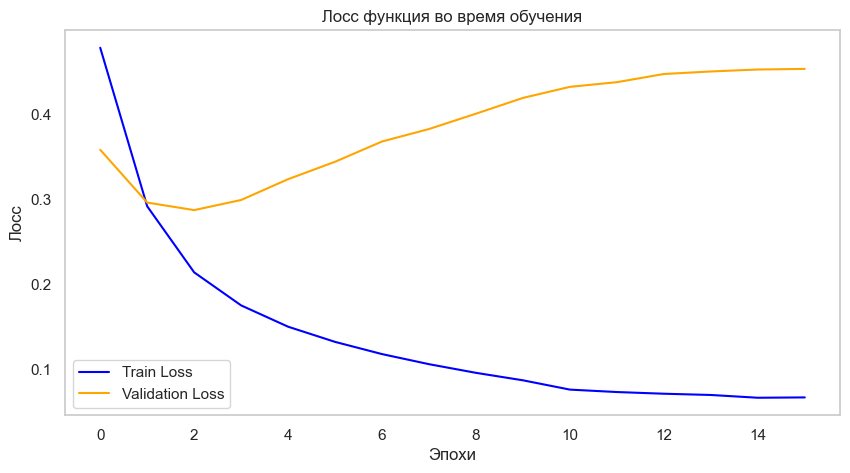

In [9]:
# 5. –û–±—É—á–µ–Ω–∏–µ
num_samples = len(y_train_final)
num_positives_per_class = np.sum(y_train_final, axis=0)
num_negatives_per_class = num_samples - num_positives_per_class
pos_weight = num_negatives_per_class / (num_positives_per_class + 1e-6)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion_tfidf = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)
optimizer_tfidf = optim.AdamW(model_tfidf_nn.parameters(), lr=1e-3)
scheduler_tfidf = ReduceLROnPlateau(optimizer_tfidf, mode='max', factor=0.2, patience=1)

best_val_auc_tfidf = -1.0
early_stopping_counter_tfidf = 0
train_losses_tfidf, val_losses_tfidf, train_aucs_tfidf, val_aucs_tfidf, lr_tfidf = [], [], [], [], []

for epoch in range(20):
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1} (TFIDF+MLP) ---")
    lr_tfidf.append(optimizer_tfidf.param_groups[0]['lr'])
    print(f"LR: {lr_tfidf[-1]:.6f}")

    train_loss, train_auc = train_loop(model_tfidf_nn, train_loader_tfidf, criterion_tfidf, optimizer_tfidf, device, is_rnn_or_cnn=False)
    val_loss, val_auc = evaluate_loop(model_tfidf_nn, val_loader_tfidf, criterion_tfidf, device, is_rnn_or_cnn=False)
    train_losses_tfidf.append(train_loss)
    val_losses_tfidf.append(val_loss)
    train_aucs_tfidf.append(train_auc)
    val_aucs_tfidf.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_tfidf.step(val_auc)
    if val_auc > best_val_auc_tfidf:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_tfidf:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_tfidf = val_auc
        torch.save(model_tfidf_nn.state_dict(), MODEL_PATHS["tfidf_mlp"])
        early_stopping_counter_tfidf = 0
    else:
        early_stopping_counter_tfidf += 1

    if early_stopping_counter_tfidf >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses_tfidf, label='Train Loss', color='blue')
plt.plot(val_losses_tfidf, label='Validation Loss', color='orange')
plt.title('–õ–æ—Å—Å —Ñ—É–Ω–∫—Ü–∏—è –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–õ–æ—Å—Å')
plt.legend()
plt.grid()

–¥–∞–∂–µ –ø—Ä–∏ —É—Å–ª–æ–≤–∏–∏ —á—Ç–æ –¥–æ–≤–æ–ª—å–Ω–æ —Å—Ç—Ä–∞–Ω–Ω–æ —Å–µ–±—è –≤–µ–¥—ë—Ç –ª–æ—Å—Å, —Ö–æ—Ç—è roc auc –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç—Å—è - —Å–∫–æ—Ä –æ—Ç —ç—Ç–æ–≥–æ –ª—É—á—à–µ –Ω–∞ –ø–∞–±–ª–∏–∫–µ \
0.835 –Ω–∞ –ø—Ä–∞–π–≤–∞—Ç–µ –∏ 0.840 –Ω–∞ –ø–∞–±–ª–∏–∫–µ

## Word2Vec + LSTM

In [10]:
# 1. –û–±—É—á–µ–Ω–∏–µ Word2Vec
sentences_for_w2v = [
    word_tokenize(str(text)) 
    for text in tqdm(train_split_df['text_cleaned_sequential']) 
    if isinstance(text, str) and text.strip()
]

w2v_model = Word2Vec(
    sentences=sentences_for_w2v, 
    vector_size=W2V_VECTOR_SIZE, 
    window=W2V_WINDOW, 
    min_count=W2V_MIN_COUNT, 
    workers=W2V_WORKERS, 
    epochs=W2V_EPOCHS, 
    sg=1, 
    seed=SEED
)

globals()['word_to_idx'] = {word: idx + 2 for idx, word in enumerate(w2v_model.wv.index_to_key)}
globals()['word_to_idx']['<PAD>'] = PAD_IDX
globals()['word_to_idx']['<UNK>'] = UNK_IDX
globals()['VOCAB_SIZE'] = len(word_to_idx)
print(f"–†–∞–∑–º–µ—Ä —Å–ª–æ–≤–∞—Ä—è Word2Vec (–≥–ª–æ–±–∞–ª—å–Ω—ã–π VOCAB_SIZE): {VOCAB_SIZE}")
print(f"–ì–ª–æ–±–∞–ª—å–Ω—ã–π PAD_IDX: {PAD_IDX}, UNK_IDX: {UNK_IDX}")

VOCAB_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "word_to_idx.json")
print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Å–ª–æ–≤–∞—Ä—è –≤ {VOCAB_SAVE_PATH}...")
with open(VOCAB_SAVE_PATH, 'w', encoding='utf8') as f:
    json.dump(word_to_idx, f, ensure_ascii=False, indent=4)
print("–°–ª–æ–≤–∞—Ä—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω.")

# 2. –°–æ–∑–¥–∞–Ω–∏–µ Embedding-–º–∞—Ç—Ä–∏—Ü—ã
embedding_matrix = np.zeros((VOCAB_SIZE, W2V_VECTOR_SIZE))
for word, idx_val in word_to_idx.items():
    if idx_val > UNK_IDX and word in w2v_model.wv:
        embedding_matrix[idx_val] = w2v_model.wv[word]
embedding_matrix[UNK_IDX] = np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(f"Embedding –º–∞—Ç—Ä–∏—Ü–∞: {embedding_matrix.shape}")

# 3. –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–µ–∫—Å—Ç–æ–≤ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ (–∏—Å–ø–æ–ª—å–∑—É–µ—Ç –≥–ª–æ–±–∞–ª—å–Ω—ã–π word_to_idx)
train_sequences = [
    text_to_sequence(text, word_to_idx) 
    for text in tqdm(train_split_df['text_cleaned_sequential'], desc="Train Seq")
]
val_sequences = [
    text_to_sequence(text, word_to_idx) 
    for text in tqdm(val_split_df['text_cleaned_sequential'], desc="Val Seq")
]

current_notebook_pad_idx = PAD_IDX
current_notebook_unk_idx = UNK_IDX

collate_fn_for_w2v_lstm = functools.partial(
    collate_batch_configurable,
    pad_idx_value=current_notebook_pad_idx,
    unk_idx_value=current_notebook_unk_idx
)

# 4. Dataset –∏ DataLoader
train_seq_dataset = SequenceDataset(train_sequences, y_train_final, MAX_LEN)
val_seq_dataset = SequenceDataset(val_sequences, y_val_final, MAX_LEN)
train_seq_loader = DataLoader(train_seq_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
SEQ_DATALOADERS_CREATED = True

model_w2v_lstm = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX, embedding_matrix, FREEZE_EMBEDDINGS).to(device)

  0%|          | 0/21545 [00:00<?, ?it/s]

–†–∞–∑–º–µ—Ä —Å–ª–æ–≤–∞—Ä—è Word2Vec (–≥–ª–æ–±–∞–ª—å–Ω—ã–π VOCAB_SIZE): 39759
–ì–ª–æ–±–∞–ª—å–Ω—ã–π PAD_IDX: 0, UNK_IDX: 1
–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Å–ª–æ–≤–∞—Ä—è –≤ ./trained_models/word_to_idx.json...
–°–ª–æ–≤–∞—Ä—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω.
Embedding –º–∞—Ç—Ä–∏—Ü–∞: torch.Size([39759, 300])


Train Seq:   0%|          | 0/21545 [00:00<?, ?it/s]

Val Seq:   0%|          | 0/5422 [00:00<?, ?it/s]

–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è W2V+LSTM...
–û–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω—ã–µ pos_weight –¥–ª—è LSTM (train): tensor([ 0.8408,  0.5454, 19.3063, 15.7145,  0.6254, 20.0000, 20.0000,  0.3005,
         0.2712,  0.4368,  1.3227,  0.5984,  0.2628,  0.2880,  0.3123,  0.9955,
         0.3535,  0.2542,  0.2142,  4.1592], device='mps:0')

--- –≠–ø–æ—Ö–∞ 1 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4229 | Train AUC: 0.7807
Val Loss:   0.3183 | Val AUC:   0.8856
Val AUC —É–ª—É—á—à–∏–ª—Å—è (-1.0000 -> 0.8856). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 2 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2937 | Train AUC: 0.8915
Val Loss:   0.2781 | Val AUC:   0.9076
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.8856 -> 0.9076). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 3 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2371 | Train AUC: 0.9190
Val Loss:   0.2765 | Val AUC:   0.9140
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9076 -> 0.9140). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 4 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1987 | Train AUC: 0.9348
Val Loss:   0.3037 | Val AUC:   0.9157
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9140 -> 0.9157). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 5 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1774 | Train AUC: 0.9435
Val Loss:   0.3081 | Val AUC:   0.9153

--- –≠–ø–æ—Ö–∞ 6 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1596 | Train AUC: 0.9507
Val Loss:   0.3489 | Val AUC:   0.9201
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9157 -> 0.9201). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 7 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1450 | Train AUC: 0.9569
Val Loss:   0.3390 | Val AUC:   0.9219
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9201 -> 0.9219). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 8 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1340 | Train AUC: 0.9618
Val Loss:   0.3443 | Val AUC:   0.9236
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9219 -> 0.9236). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 9 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1241 | Train AUC: 0.9656
Val Loss:   0.3792 | Val AUC:   0.9253
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9236 -> 0.9253). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 10 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1143 | Train AUC: 0.9694
Val Loss:   0.4000 | Val AUC:   0.9248

--- –≠–ø–æ—Ö–∞ 11 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1084 | Train AUC: 0.9718
Val Loss:   0.4007 | Val AUC:   0.9245

--- –≠–ø–æ—Ö–∞ 12 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0951 | Train AUC: 0.9765
Val Loss:   0.4171 | Val AUC:   0.9263
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9253 -> 0.9263). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 13 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0891 | Train AUC: 0.9781
Val Loss:   0.4308 | Val AUC:   0.9262

--- –≠–ø–æ—Ö–∞ 14 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0855 | Train AUC: 0.9792
Val Loss:   0.4421 | Val AUC:   0.9262

--- –≠–ø–æ—Ö–∞ 15 (W2V+LSTM) ---
LR: 0.000020


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0818 | Train AUC: 0.9803
Val Loss:   0.4447 | Val AUC:   0.9262
–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ 15.


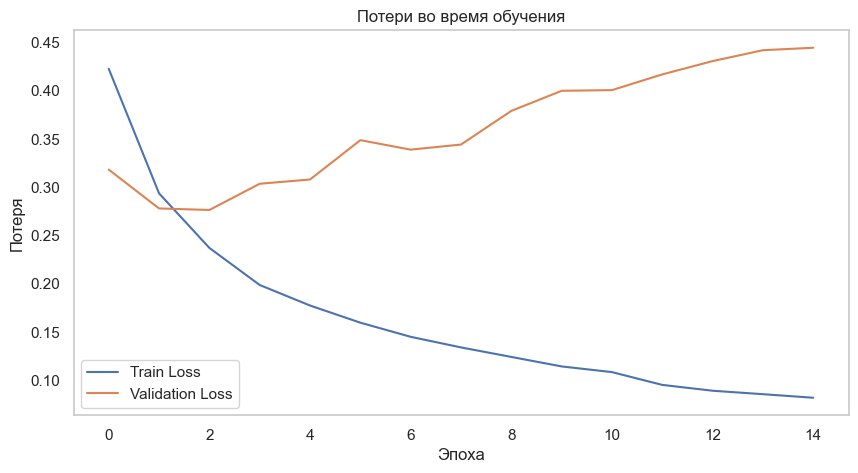

In [11]:
# 6. –û–±—É—á–µ–Ω–∏–µ
print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è W2V+LSTM...")

# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –æ–±—Ä–∞–∑—Ü–æ–≤ –∏ –∫–ª–∞—Å—Å–æ–≤
num_samples_train = len(y_train_final)
num_positives_per_class_train = np.sum(y_train_final, axis=0)
num_negatives_per_class_train = num_samples_train - num_positives_per_class_train

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –≤–µ—Å–∞ –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∞
pos_weight_train = num_negatives_per_class_train / (num_positives_per_class_train + 1e-6)
pos_weight_train_tensor = torch.tensor(pos_weight_train, dtype=torch.float32).to(device)
pos_weight_train_tensor_clipped = torch.clamp(pos_weight_train_tensor, max=MAX_POS_WEIGHT)

print(f"–û–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω—ã–µ pos_weight –¥–ª—è LSTM (train): {pos_weight_train_tensor_clipped}")

criterion_w2v = nn.BCEWithLogitsLoss(pos_weight=pos_weight_train_tensor_clipped).to(device)
optimizer_w2v = optim.AdamW(model_w2v_lstm.parameters(), lr=5e-4)
scheduler_w2v = ReduceLROnPlateau(optimizer_w2v, mode='max', factor=0.2, patience=1)

best_val_auc_w2v = -1.0
early_stopping_counter_w2v = 0
train_losses_w2v, val_losses_w2v, train_aucs_w2v, val_aucs_w2v, lr_w2v = [], [], [], [], []

for epoch in range(20):
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1} (W2V+LSTM) ---")
    lr_w2v.append(optimizer_w2v.param_groups[0]['lr'])
    print(f"LR: {lr_w2v[-1]:.6f}")

    train_loss, train_auc = train_loop(model_w2v_lstm, train_seq_loader, criterion_w2v, optimizer_w2v, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_w2v_lstm, val_seq_loader, criterion_w2v, device, is_rnn_or_cnn='rnn')

    train_losses_w2v.append(train_loss)
    val_losses_w2v.append(val_loss)
    train_aucs_w2v.append(train_auc)
    val_aucs_w2v.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_w2v.step(val_auc)

    if val_auc > best_val_auc_w2v:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_w2v:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_w2v = val_auc
        torch.save(model_w2v_lstm.state_dict(), MODEL_PATHS["w2v_lstm"])
        early_stopping_counter_w2v = 0
    else:
        early_stopping_counter_w2v += 1

    # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ —Ä–∞–Ω–Ω—é—é –æ—Å—Ç–∞–Ω–æ–≤–∫—É
    if early_stopping_counter_w2v >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses_w2v, label='Train Loss')
plt.plot(val_losses_w2v, label='Validation Loss')
plt.title('–ü–æ—Ç–µ—Ä–∏ –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('–ü–æ—Ç–µ—Ä—è')
plt.legend()
plt.grid()
plt.show()

## CNN + Trainable Emb

--- –≠—Ç–∞–ø 3 (–ü–∞–π–ø–ª–∞–π–Ω 3): CNN + Trainable Emb (—Å –≤–∑–≤–µ—à–∏–≤–∞–Ω–∏–µ–º –∫–ª–∞—Å—Å–æ–≤) ---
–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è CNN+Emb (—Å –≤–∑–≤–µ—à–∏–≤–∞–Ω–∏–µ–º –∫–ª–∞—Å—Å–æ–≤)...
–û–ì–†–ê–ù–ò–ß–ï–ù–ù–´–ï pos_weight –¥–ª—è CNN: tensor([ 0.8408,  0.5454, 19.3063, 15.7145,  0.6254, 20.0000, 20.0000,  0.3005,
         0.2712,  0.4368,  1.3227,  0.5984,  0.2628,  0.2880,  0.3123,  0.9955,
         0.3535,  0.2542,  0.2142,  4.1592], device='mps:0')

--- –≠–ø–æ—Ö–∞ 1 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4499 | Train AUC: 0.7487
Val Loss:   0.3198 | Val AUC:   0.8778
Val AUC —É–ª—É—á—à–∏–ª—Å—è (-1.0000 -> 0.8778). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 2 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.3359 | Train AUC: 0.8640
Val Loss:   0.2773 | Val AUC:   0.9199
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.8778 -> 0.9199). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 3 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2976 | Train AUC: 0.8928
Val Loss:   0.2599 | Val AUC:   0.9290
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9199 -> 0.9290). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 4 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2695 | Train AUC: 0.9075
Val Loss:   0.2635 | Val AUC:   0.9319
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9290 -> 0.9319). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 5 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2495 | Train AUC: 0.9162
Val Loss:   0.2527 | Val AUC:   0.9349
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9319 -> 0.9349). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 6 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2327 | Train AUC: 0.9229
Val Loss:   0.2554 | Val AUC:   0.9363
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9349 -> 0.9363). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 7 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2196 | Train AUC: 0.9289
Val Loss:   0.2586 | Val AUC:   0.9374
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9363 -> 0.9374). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 8 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2038 | Train AUC: 0.9351
Val Loss:   0.2722 | Val AUC:   0.9392
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9374 -> 0.9392). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 9 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1952 | Train AUC: 0.9398
Val Loss:   0.2577 | Val AUC:   0.9394
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9392 -> 0.9394). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 10 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1859 | Train AUC: 0.9437
Val Loss:   0.2762 | Val AUC:   0.9399
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9394 -> 0.9399). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 11 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1761 | Train AUC: 0.9477
Val Loss:   0.3088 | Val AUC:   0.9397

--- –≠–ø–æ—Ö–∞ 12 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1688 | Train AUC: 0.9514
Val Loss:   0.3132 | Val AUC:   0.9401
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9399 -> 0.9401). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 13 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1610 | Train AUC: 0.9544
Val Loss:   0.2965 | Val AUC:   0.9407
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9401 -> 0.9407). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 14 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1550 | Train AUC: 0.9569
Val Loss:   0.3186 | Val AUC:   0.9406

--- –≠–ø–æ—Ö–∞ 15 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1485 | Train AUC: 0.9600
Val Loss:   0.3159 | Val AUC:   0.9406

--- –≠–ø–æ—Ö–∞ 16 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1414 | Train AUC: 0.9624
Val Loss:   0.3721 | Val AUC:   0.9400
–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ 16.

–û–±—É—á–µ–Ω–∏–µ CNN+Emb –∑–∞–≤–µ—Ä—à–µ–Ω–æ.
–õ—É—á—à–∞—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å CNN+Emb –∏–º–µ–ª–∞ Val AUC: 0.9407


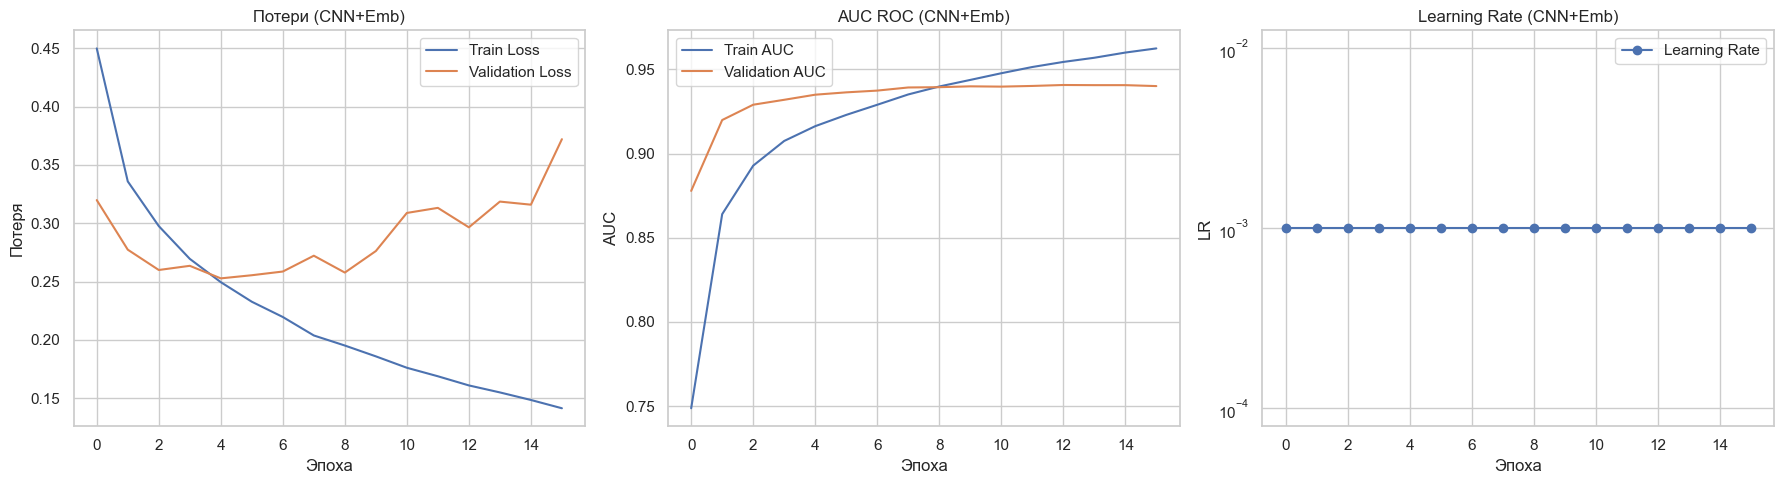

In [12]:
print("--- –≠—Ç–∞–ø 3 (–ü–∞–π–ø–ª–∞–π–Ω 3): CNN + Trainable Emb (—Å –≤–∑–≤–µ—à–∏–≤–∞–Ω–∏–µ–º –∫–ª–∞—Å—Å–æ–≤) ---")

model_cnn = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)

print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è CNN+Emb (—Å –≤–∑–≤–µ—à–∏–≤–∞–Ω–∏–µ–º –∫–ª–∞—Å—Å–æ–≤)...")

num_samples_cnn = len(y_train_final)
num_positives_per_class_cnn = np.sum(y_train_final, axis=0)
num_negatives_per_class_cnn = num_samples_cnn - num_positives_per_class_cnn
pos_weight_cnn_raw = num_negatives_per_class_cnn / (num_positives_per_class_cnn + 1e-6)

pos_weight_cnn_clipped = np.clip(pos_weight_cnn_raw, None, MAX_POS_WEIGHT)
pos_weight_tensor_cnn = torch.tensor(pos_weight_cnn_clipped, dtype=torch.float32).to(device)
print(f"–û–ì–†–ê–ù–ò–ß–ï–ù–ù–´–ï pos_weight –¥–ª—è CNN: {pos_weight_tensor_cnn}")

criterion_cnn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor_cnn).to(device)

optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_cnn = ReduceLROnPlateau(optimizer_cnn, mode='max', factor=0.2, patience=2, threshold=0.0001, threshold_mode='abs')

best_val_auc_cnn = -1.0
early_stopping_counter_cnn = 0

train_losses_cnn, val_losses_cnn, train_aucs_cnn, val_aucs_cnn, lr_cnn = [], [], [], [], []

MAX_EPOCHS_CNN = 20

for epoch in range(MAX_EPOCHS_CNN):
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1} (CNN+Emb) ---")
    lr_cnn.append(optimizer_cnn.param_groups[0]['lr'])
    print(f"LR: {lr_cnn[-1]:.6f}")

    train_loss, train_auc = train_loop(model_cnn, train_seq_loader, criterion_cnn, optimizer_cnn, device, is_rnn_or_cnn='cnn')
    val_loss, val_auc = evaluate_loop(model_cnn, val_seq_loader, criterion_cnn, device, is_rnn_or_cnn='cnn')
    
    train_losses_cnn.append(train_loss)
    val_losses_cnn.append(val_loss)
    train_aucs_cnn.append(train_auc)
    val_aucs_cnn.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_cnn.step(val_auc)

    if val_auc > best_val_auc_cnn:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_cnn:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_cnn = val_auc
        torch.save(model_cnn.state_dict(), MODEL_PATHS["cnn_emb"])
        early_stopping_counter_cnn = 0
    else:
        early_stopping_counter_cnn += 1

    # –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è —Ä–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –ø–æ Val Loss
    # if val_loss < best_val_loss_cnn - 0.0001: # –°—á–∏—Ç–∞–µ–º —É–ª—É—á—à–µ–Ω–∏–µ–º, –µ—Å–ª–∏ –ª–æ—Å—Å —É–ø–∞–ª —Ö–æ—Ç—è –±—ã –Ω–∞ –Ω–µ–º–Ω–æ–≥–æ
    #     print(f"Val Loss —É–ª—É—á—à–∏–ª—Å—è ({best_val_loss_cnn:.4f} -> {val_loss:.4f}). Val AUC: {val_auc:.4f}. –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
    #     best_val_loss_cnn = val_loss
    #     best_val_auc_at_best_loss_cnn = val_auc
    #     torch.save(model_cnn.state_dict(), MODEL_PATHS["cnn_emb"])
    #     early_stopping_counter_cnn = 0
    # else:
    #     early_stopping_counter_cnn += 1
    #     print(f"Val Loss –Ω–µ —É–ª—É—á—à–∏–ª—Å—è –∏–ª–∏ —É–ª—É—á—à–∏–ª—Å—è –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ. –°—á–µ—Ç—á–∏–∫ —Ä–∞–Ω–Ω–µ–π –æ—Å—Ç–∞–Ω–æ–≤–∫–∏: {early_stopping_counter_cnn}.")


    if early_stopping_counter_cnn >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        # if best_val_auc_at_best_loss_cnn != -1.0: # –ï—Å–ª–∏ –æ—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–ª–∏—Å—å –ø–æ –ª–æ—Å—Å—É
        #     print(f"–õ—É—á—à–∏–π Val AUC, –¥–æ—Å—Ç–∏–≥–Ω—É—Ç—ã–π –ø—Ä–∏ –ª—É—á—à–µ–º Val Loss ({best_val_loss_cnn:.4f}), –±—ã–ª: {best_val_auc_at_best_loss_cnn:.4f}")
        break

print("\n–û–±—É—á–µ–Ω–∏–µ CNN+Emb –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")
if best_val_auc_cnn != -1.0:
     print(f"–õ—É—á—à–∞—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å CNN+Emb –∏–º–µ–ª–∞ Val AUC: {best_val_auc_cnn:.4f}")

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses_cnn, label='Train Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.title('–ü–æ—Ç–µ—Ä–∏ (CNN+Emb)')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('–ü–æ—Ç–µ—Ä—è')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_aucs_cnn, label='Train AUC')
plt.plot(val_aucs_cnn, label='Validation AUC')
plt.title('AUC ROC (CNN+Emb)')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(lr_cnn, label='Learning Rate', marker='o')
plt.title('Learning Rate (CNN+Emb)')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('LR'); plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## LSTM + Trainable Emb

–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è LSTM+TrainableEmb...

--- –≠–ø–æ—Ö–∞ 1 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.3476 | Train AUC: 0.8154
Val Loss:   0.2688 | Val AUC:   0.8999
Val AUC —É–ª—É—á—à–∏–ª—Å—è (-1.0000 -> 0.8999). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 2 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2491 | Train AUC: 0.9046
Val Loss:   0.2349 | Val AUC:   0.9180
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.8999 -> 0.9180). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 3 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2237 | Train AUC: 0.9228
Val Loss:   0.2217 | Val AUC:   0.9276
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9180 -> 0.9276). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 4 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1997 | Train AUC: 0.9388
Val Loss:   0.2151 | Val AUC:   0.9321
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9276 -> 0.9321). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 5 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1798 | Train AUC: 0.9492
Val Loss:   0.2057 | Val AUC:   0.9371
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9321 -> 0.9371). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 6 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1621 | Train AUC: 0.9583
Val Loss:   0.2054 | Val AUC:   0.9397
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9371 -> 0.9397). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 7 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1458 | Train AUC: 0.9656
Val Loss:   0.2051 | Val AUC:   0.9413
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9397 -> 0.9413). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 8 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1317 | Train AUC: 0.9709
Val Loss:   0.2076 | Val AUC:   0.9428
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9413 -> 0.9428). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 9 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1181 | Train AUC: 0.9767
Val Loss:   0.2055 | Val AUC:   0.9442
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9428 -> 0.9442). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 10 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1051 | Train AUC: 0.9812
Val Loss:   0.2118 | Val AUC:   0.9435

--- –≠–ø–æ—Ö–∞ 11 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0946 | Train AUC: 0.9848
Val Loss:   0.2155 | Val AUC:   0.9445
Val AUC —É–ª—É—á—à–∏–ª—Å—è (0.9442 -> 0.9445). –°–æ—Ö—Ä–∞–Ω—è–µ–º...

--- –≠–ø–æ—Ö–∞ 12 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0856 | Train AUC: 0.9874
Val Loss:   0.2243 | Val AUC:   0.9434

--- –≠–ø–æ—Ö–∞ 13 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0776 | Train AUC: 0.9899
Val Loss:   0.2352 | Val AUC:   0.9431

--- –≠–ø–æ—Ö–∞ 14 (LSTM+TrainableEmb) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0630 | Train AUC: 0.9936
Val Loss:   0.2339 | Val AUC:   0.9442
–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ 14.


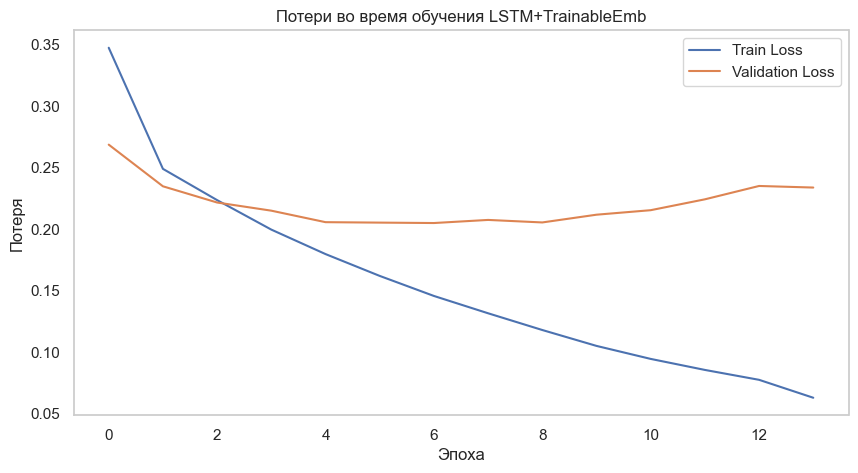


–û–±—É—á–µ–Ω–∏–µ LSTM+TrainableEmb –∑–∞–≤–µ—Ä—à–µ–Ω–æ.


In [13]:
model_rnn_te = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, 
                                           OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, 
                                           RNN_TE_DROPOUT, PAD_IDX).to(device)

# –û–±—É—á–µ–Ω–∏–µ
print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è LSTM+TrainableEmb...")
criterion_rnn_te = nn.BCEWithLogitsLoss().to(device)
optimizer_rnn_te = optim.AdamW(model_rnn_te.parameters(), lr=1e-3)
scheduler_rnn_te = ReduceLROnPlateau(optimizer_rnn_te, mode='max', factor=0.2, patience=1)

best_val_auc_rnn_te = -1.0
early_stopping_counter_rnn_te = 0
train_losses_rnn_te, val_losses_rnn_te, train_aucs_rnn_te, val_aucs_rnn_te, lr_rnn_te = [], [], [], [], []

for epoch in range(20): 
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1} (LSTM+TrainableEmb) ---")
    lr_rnn_te.append(optimizer_rnn_te.param_groups[0]['lr'])
    print(f"LR: {lr_rnn_te[-1]:.6f}")

    train_loss, train_auc = train_loop(model_rnn_te, train_seq_loader, criterion_rnn_te, optimizer_rnn_te, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_rnn_te, val_seq_loader, criterion_rnn_te, device, is_rnn_or_cnn='rnn')
    train_losses_rnn_te.append(train_loss)
    val_losses_rnn_te.append(val_loss)
    train_aucs_rnn_te.append(train_auc)
    val_aucs_rnn_te.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_rnn_te.step(val_auc)
    if val_auc > best_val_auc_rnn_te:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_rnn_te:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_rnn_te = val_auc
        torch.save(model_rnn_te.state_dict(), MODEL_PATHS["rnn_emb"])
        early_stopping_counter_rnn_te = 0
    else:
        early_stopping_counter_rnn_te += 1

    if early_stopping_counter_rnn_te >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        break

# –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.figure(figsize=(10, 5))
plt.plot(train_losses_rnn_te, label='Train Loss')
plt.plot(val_losses_rnn_te, label='Validation Loss')
plt.title('–ü–æ—Ç–µ—Ä–∏ –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è LSTM+TrainableEmb')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('–ü–æ—Ç–µ—Ä—è')
plt.legend()
plt.grid()
plt.show()

print("\n–û–±—É—á–µ–Ω–∏–µ LSTM+TrainableEmb –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")

## cointegrated/rubert-tiny2 (BERT)

In [17]:
# 1. –ú–æ–¥–µ–ª—å –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä
print(f"–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: {MODEL_NAME_BERT_TINY}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_BERT_TINY)
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERT_TINY,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)

TOKENIZER_LOADED = True
MODEL_LOADED = True
print("–ú–æ–¥–µ–ª—å –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä BERT –∑–∞–≥—Ä—É–∂–µ–Ω—ã.")

# 2. –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
print("–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è...")
TEXT_COLUMN = 'text_cleaned_bert'

def tokenize_function(examples):
    return tokenizer(examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=BERT_MAX_LEN)

train_labels_float = [list(map(float, row)) for row in y_train_final]
val_labels_float = [list(map(float, row)) for row in y_val_final]

train_dict = {
    'id': train_split_df['id'].tolist(),
    TEXT_COLUMN: train_split_df[TEXT_COLUMN].tolist(),
    'labels': train_labels_float
}

val_dict = {
    'id': val_split_df['id'].tolist(),
    TEXT_COLUMN: val_split_df[TEXT_COLUMN].tolist(),
    'labels': val_labels_float
}

hg_train_dataset = HFDataset.from_dict(train_dict)
hg_val_dataset = HFDataset.from_dict(val_dict)

tokenized_train_dataset = hg_train_dataset.map(tokenize_function, batched=True, remove_columns=[TEXT_COLUMN, "id"])
tokenized_val_dataset = hg_val_dataset.map(tokenize_function, batched=True, remove_columns=[TEXT_COLUMN, "id"])

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
BERT_DATA_READY = True
print("–î–∞–Ω–Ω—ã–µ –¥–ª—è BERT –≥–æ—Ç–æ–≤—ã.")

# 3. –ù–∞—Å—Ç—Ä–æ–π–∫–∞ Trainer
print("–ù–∞—Å—Ç—Ä–æ–π–∫–∞ Trainer...")

if len(tokenized_train_dataset) > 0 and BERT_TINY_BATCH_SIZE > 0: # <--- –ò–ó–ú–ï–ù–ï–ù–û
    steps_per_epoch = math.ceil(len(tokenized_train_dataset) / BERT_TINY_BATCH_SIZE) # <--- –ò–ó–ú–ï–ù–ï–ù–û
    logging_steps = max(1, steps_per_epoch // 10)
else:
    logging_steps = 50
print(f"–®–∞–≥ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –¥–ª—è rubert-tiny2: {logging_steps}")

training_args_tiny = TrainingArguments(
    output_dir=OUTPUT_DIR_BERT_TINY,
    num_train_epochs=BERT_TINY_EPOCHS,
    per_device_train_batch_size=BERT_TINY_BATCH_SIZE,
    learning_rate=BERT_TINY_LR,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_DIR_BERT_TINY}/logs",
    logging_steps=logging_steps,
    report_to="none",
    dataloader_num_workers=0,
)

trainer_tiny = Trainer(
    model=model_bert,
    args=training_args_tiny,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)
print("trainer_tiny —Å–æ–∑–¥–∞–Ω.")

–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: cointegrated/rubert-tiny2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


–ú–æ–¥–µ–ª—å –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä BERT –∑–∞–≥—Ä—É–∂–µ–Ω—ã.
–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è...


Map:   0%|          | 0/21545 [00:00<?, ? examples/s]

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

–î–∞–Ω–Ω—ã–µ –¥–ª—è BERT –≥–æ—Ç–æ–≤—ã.
–ù–∞—Å—Ç—Ä–æ–π–∫–∞ Trainer...
–®–∞–≥ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –¥–ª—è rubert-tiny2: 134
trainer_tiny —Å–æ–∑–¥–∞–Ω.


In [18]:
# –û–±—É—á–µ–Ω–∏–µ BERT
print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è BERT...")
train_results_tiny = trainer_tiny.train()
print("–û–±—É—á–µ–Ω–∏–µ BERT –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")

# –û—Ü–µ–Ω–∫–∞ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ü–û–°–õ–ï–î–ù–ï–ô –º–æ–¥–µ–ª–∏
print("–û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2...")
eval_results_tiny = trainer_tiny.evaluate()
print(eval_results_tiny)
print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2 –≤ {MODEL_PATHS['bert_tiny']}...")
trainer_tiny.save_model(MODEL_PATHS['bert_tiny'])
if TOKENIZER_LOADED:
    tokenizer.save_pretrained(MODEL_PATHS['bert_tiny'])
print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2 –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")

–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è BERT...


/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 

–û–±—É—á–µ–Ω–∏–µ BERT –∑–∞–≤–µ—Ä—à–µ–Ω–æ.
–û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2...


/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.23153647780418396, 'eval_roc_auc_macro': 0.9063949646199478, 'eval_runtime': 13.9693, 'eval_samples_per_second': 388.135, 'eval_steps_per_second': 48.535, 'epoch': 5.0}
–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2 –≤ ./trained_models/bert_tiny_final_model...
–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ rubert-tiny2 –∑–∞–≤–µ—Ä—à–µ–Ω–æ.


In [19]:
# --- –û—á–∏—Å—Ç–∫–∞ –ø–∞–º—è—Ç–∏ –ü–û–°–õ–ï —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è ---
print("–û—á–∏—Å—Ç–∫–∞ –ø–∞–º—è—Ç–∏ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è rubert-tiny2...")
del model_bert # –£–¥–∞–ª—è–µ–º –º–æ–¥–µ–ª—å –∏–∑ –ø–∞–º—è—Ç–∏
del trainer_tiny # –£–¥–∞–ª—è–µ–º Trainer
if 'training_args_tiny' in locals(): del training_args_tiny
if 'train_results_tiny' in locals(): del train_results_tiny
if 'eval_results_tiny' in locals(): del eval_results_tiny
if 'loss_values_plot' in locals(): del loss_values_plot # –ï—Å–ª–∏ —Å–æ–∑–¥–∞–≤–∞–ª–∏

if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("–ü–∞–º—è—Ç—å –æ—á–∏—â–µ–Ω–∞.")

–û—á–∏—Å—Ç–∫–∞ –ø–∞–º—è—Ç–∏ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è rubert-tiny2...
–ü–∞–º—è—Ç—å –æ—á–∏—â–µ–Ω–∞.


## sergeyzh/BERTA (BERT)

In [20]:
MODEL_PATHS["berta_classifier_v1"] = os.path.join(MODEL_SAVE_DIR, "berta_v1_final_model")

print(f"–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: {MODEL_NAME_BERTA_V1}")
tokenizer_berta_v1 = AutoTokenizer.from_pretrained(MODEL_NAME_BERTA_V1)
model_berta_v1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERTA_V1,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)

print(f"–¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∏ –º–æ–¥–µ–ª—å BERTA ({MODEL_NAME_BERTA_V1}) –∑–∞–≥—Ä—É–∂–µ–Ω—ã.")
print(f"BERTA (V1): —Ä–µ–∞–ª—å–Ω—ã–π –±–∞—Ç—á = {BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE}, "
      f"–Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ = {BERTA_V1_GRAD_ACCUM_STEPS}, "
      f"–º–∞–∫—Å.–¥–ª–∏–Ω–∞ = {BERTA_V1_MAX_LEN}")

print("–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–ª—è BERTA (V1)...")
TEXT_COLUMN_BERT = 'text_cleaned_bert'

def tokenize_function_berta_v1(examples):
    return tokenizer_berta_v1(
        examples[TEXT_COLUMN_BERT], padding="max_length", truncation=True,
        max_length=BERTA_V1_MAX_LEN
    )

train_labels_float_berta_v1 = [list(map(float, row)) for row in y_train_final]
val_labels_float_berta_v1 = [list(map(float, row)) for row in y_val_final]
train_dict_berta_v1 = {'id': train_split_df['id'].tolist(), TEXT_COLUMN_BERT: train_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': train_labels_float_berta_v1}
val_dict_berta_v1 = {'id': val_split_df['id'].tolist(), TEXT_COLUMN_BERT: val_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': val_labels_float_berta_v1}

hg_train_dataset_berta_v1 = HFDataset.from_dict(train_dict_berta_v1)
hg_val_dataset_berta_v1 = HFDataset.from_dict(val_dict_berta_v1)

tokenized_train_dataset_berta_v1 = hg_train_dataset_berta_v1.map(tokenize_function_berta_v1, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])
tokenized_val_dataset_berta_v1 = hg_val_dataset_berta_v1.map(tokenize_function_berta_v1, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])

tokenized_train_dataset_berta_v1.set_format("torch")
tokenized_val_dataset_berta_v1.set_format("torch")
print("–î–∞–Ω–Ω—ã–µ –¥–ª—è BERTA (V1) –≥–æ—Ç–æ–≤—ã.")

os.makedirs(OUTPUT_DIR_BERTA_V1, exist_ok=True)

update_steps_per_epoch_berta_v1 = math.ceil(len(tokenized_train_dataset_berta_v1) / (BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE * BERTA_V1_GRAD_ACCUM_STEPS))
logging_steps_berta_v1 = max(1, update_steps_per_epoch_berta_v1 // 10)
effective_eval_steps_v1 = update_steps_per_epoch_berta_v1
effective_save_steps_v1 = update_steps_per_epoch_berta_v1

print(f"–®–∞–≥ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è BERTA (V1): {logging_steps_berta_v1}")
print(f"–®–∞–≥ –æ—Ü–µ–Ω–∫–∏ BERTA (V1) (eval_steps): {effective_eval_steps_v1}")
print(f"–®–∞–≥ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è BERTA (V1) (save_steps): {effective_save_steps_v1}")

training_args_berta_v1 = TrainingArguments(
    output_dir=OUTPUT_DIR_BERTA_V1,
    num_train_epochs=BERTA_V1_EPOCHS,
    per_device_train_batch_size=BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE * 2,
    gradient_accumulation_steps=BERTA_V1_GRAD_ACCUM_STEPS,
    learning_rate=BERTA_V1_LR,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=effective_eval_steps_v1,
    save_steps=effective_save_steps_v1,
    do_eval=True,
    logging_strategy="steps",
    logging_steps=logging_steps_berta_v1,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    save_total_limit=2,
    fp16=False,
)

print("TrainingArguments –¥–ª—è BERTA (V1) —Å–æ–∑–¥–∞–Ω—ã —É—Å–ø–µ—à–Ω–æ!")

trainer_berta_v1 = Trainer(
    model=model_berta_v1,
    args=training_args_berta_v1,
    train_dataset=tokenized_train_dataset_berta_v1,
    eval_dataset=tokenized_val_dataset_berta_v1,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_berta_v1
)
print("Trainer –¥–ª—è BERTA (V1) —Å–æ–∑–¥–∞–Ω.")

# --- 4. –û–±—É—á–µ–Ω–∏–µ BERTA (V1) ---
print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è BERTA (V1)...")
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

try:
    train_result_berta_v1 = trainer_berta_v1.train() # –ù–æ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –¥–ª—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    print("–û–±—É—á–µ–Ω–∏–µ BERTA (V1) –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")
    trainer_berta_v1.save_metrics("train", train_result_berta_v1.metrics)
except Exception as e:
    print(f"–û—à–∏–±–∫–∞ –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è BERTA (V1): {e}")
    raise

print("–û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (V1) –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–º –Ω–∞–±–æ—Ä–µ...")
eval_results_berta_v1 = trainer_berta_v1.evaluate(eval_dataset=tokenized_val_dataset_berta_v1)
print("–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –æ—Ü–µ–Ω–∫–∏ BERTA (V1):")
print(eval_results_berta_v1)
trainer_berta_v1.save_metrics("eval", eval_results_berta_v1)

save_path_berta_v1 = MODEL_PATHS["berta_classifier_v1"]
print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (V1) –≤ {save_path_berta_v1}...")
trainer_berta_v1.save_model(save_path_berta_v1)
tokenizer_berta_v1.save_pretrained(save_path_berta_v1)
print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (V1) –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")

–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: sergeyzh/BERTA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/BERTA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


–¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∏ –º–æ–¥–µ–ª—å BERTA (sergeyzh/BERTA) –∑–∞–≥—Ä—É–∂–µ–Ω—ã.
BERTA (V1): —Ä–µ–∞–ª—å–Ω—ã–π –±–∞—Ç—á = 1, –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ = 8, –º–∞–∫—Å.–¥–ª–∏–Ω–∞ = 256
–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–ª—è BERTA (V1)...


Map:   0%|          | 0/21545 [00:00<?, ? examples/s]

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

KeyboardInterrupt: 

## BERTA weighted classes (v2)

In [18]:
MODEL_NAME_BERTA_V2 = "sergeyzh/BERTA"
MODEL_PATHS["berta_classifier_v2"] = os.path.join(MODEL_SAVE_DIR, "berta_classifier_v2_len512_weighted_final_model")

print(f"–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: {MODEL_NAME_BERTA_V2}")
tokenizer_berta_v2 = AutoTokenizer.from_pretrained(MODEL_NAME_BERTA_V2)
model_berta_v2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERTA_V2,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)
TOKENIZER_BERTA_V2_LOADED = True
MODEL_BERTA_V2_LOADED = True
print("–¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∏ –º–æ–¥–µ–ª—å BERTA (v2) –∑–∞–≥—Ä—É–∂–µ–Ω—ã.")

print(f"BERTA (v2): —Ä–µ–∞–ª—å–Ω—ã–π –±–∞—Ç—á = {BERTA_V2_BATCH_SIZE_PER_DEVICE}, –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ = {BERTA_V2_GRAD_ACCUM_STEPS}, –º–∞–∫—Å.–¥–ª–∏–Ω–∞ = {BERTA_V2_MAX_LEN}")

print("–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–ª—è BERTA (v2)...")
TEXT_COLUMN_BERT = 'text_cleaned_bert'

def tokenize_function_berta_v2(examples):
    return tokenizer_berta_v2(
        examples[TEXT_COLUMN_BERT], padding="max_length", truncation=True,
        max_length=BERTA_V2_MAX_LEN
    )

train_labels_float_berta_v2 = [list(map(float, row)) for row in y_train_final]
val_labels_float_berta_v2 = [list(map(float, row)) for row in y_val_final]
train_dict_berta_v2 = {'id': train_split_df['id'].tolist(), TEXT_COLUMN_BERT: train_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': train_labels_float_berta_v2}
val_dict_berta_v2 = {'id': val_split_df['id'].tolist(), TEXT_COLUMN_BERT: val_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': val_labels_float_berta_v2}

hg_train_dataset_berta_v2 = HFDataset.from_dict(train_dict_berta_v2)
hg_val_dataset_berta_v2 = HFDataset.from_dict(val_dict_berta_v2)

tokenized_train_dataset_berta_v2 = hg_train_dataset_berta_v2.map(tokenize_function_berta_v2, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])
tokenized_val_dataset_berta_v2 = hg_val_dataset_berta_v2.map(tokenize_function_berta_v2, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])

tokenized_train_dataset_berta_v2.set_format("torch")
tokenized_val_dataset_berta_v2.set_format("torch")
print("–î–∞–Ω–Ω—ã–µ –¥–ª—è BERTA (v2) –≥–æ—Ç–æ–≤—ã.")

–ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ –º–æ–¥–µ–ª–∏: sergeyzh/BERTA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/BERTA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


–¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∏ –º–æ–¥–µ–ª—å BERTA (v2) –∑–∞–≥—Ä—É–∂–µ–Ω—ã.
BERTA (v2): —Ä–µ–∞–ª—å–Ω—ã–π –±–∞—Ç—á = 2, –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ = 2, –º–∞–∫—Å.–¥–ª–∏–Ω–∞ = 384
–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ HF Datasets –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–ª—è BERTA (v2)...


Map:   0%|          | 0/21564 [00:00<?, ? examples/s]

Map:   0%|          | 0/5403 [00:00<?, ? examples/s]

–î–∞–Ω–Ω—ã–µ –¥–ª—è BERTA (v2) –≥–æ—Ç–æ–≤—ã.


In [ ]:
num_samples_train_berta_v2 = len(y_train_final)
num_positives_per_class_berta_v2 = np.sum(y_train_final, axis=0)
num_negatives_per_class_berta_v2 = num_samples_train_berta_v2 - num_positives_per_class_berta_v2
pos_weight_berta_raw = num_negatives_per_class_berta_v2 / (num_positives_per_class_berta_v2 + 1e-6)
pos_weight_berta_v2_clipped = np.clip(pos_weight_berta_raw, None, MAX_POS_WEIGHT_BERTA_V2)
pos_weight_berta_v2_tensor = torch.tensor(pos_weight_berta_v2_clipped, dtype=torch.float32).to(device)
print(f"–û–ì–†–ê–ù–ò–ß–ï–ù–ù–´–ï pos_weight –¥–ª—è BERTA (v2): {pos_weight_berta_v2_tensor}")

# --- –ö–∞—Å—Ç–æ–º–Ω—ã–π Trainer –¥–ª—è –≤–∑–≤–µ—à–µ–Ω–Ω–æ–π —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å ---
class WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weight_tensor=None, **kwargs):
        super().__init__(*args, **kwargs)
        if pos_weight_tensor is None:
            print("–ü–†–ï–î–£–ü–†–ï–ñ–î–ï–ù–ò–ï: pos_weight_tensor –Ω–µ –±—ã–ª –ø–µ—Ä–µ–¥–∞–Ω –≤ WeightedBCETrainer. –ë—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π BCEWithLogitsLoss –±–µ–∑ –≤–µ—Å–æ–≤.")
            raise ValueError("–ù–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–µ—Ä–µ–¥–∞—Ç—å pos_weight_tensor –≤ WeightedBCETrainer –¥–ª—è –≤–∑–≤–µ—à–µ–Ω–Ω–æ–π —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å.")
        self.pos_weight_tensor = pos_weight_tensor

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # <--- –î–û–ë–ê–í–õ–ï–ù–û **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

print("–ù–∞—Å—Ç—Ä–æ–π–∫–∞ Trainer –¥–ª—è BERTA (v2)...")
OUTPUT_DIR_BERTA_V2 = "./berta_v2_training_output"
os.makedirs(OUTPUT_DIR_BERTA_V2, exist_ok=True)

update_steps_per_epoch_berta_v2 = math.ceil(len(tokenized_train_dataset_berta_v2) / (BERTA_V2_BATCH_SIZE_PER_DEVICE * BERTA_V2_GRAD_ACCUM_STEPS))
logging_steps_berta_v2 = max(1, update_steps_per_epoch_berta_v2 // 10)
effective_eval_steps_v2 = update_steps_per_epoch_berta_v2
effective_save_steps_v2 = update_steps_per_epoch_berta_v2

print(f"–®–∞–≥ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è BERTA (v2): {logging_steps_berta_v2}")
print(f"–®–∞–≥ –æ—Ü–µ–Ω–∫–∏ BERTA (v2): {effective_eval_steps_v2}")
print(f"–®–∞–≥ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è BERTA (v2): {effective_save_steps_v2}")

training_args_berta_v2 = TrainingArguments(
    output_dir=OUTPUT_DIR_BERTA_V2,
    num_train_epochs=BERTA_V2_EPOCHS,
    per_device_train_batch_size=BERTA_V2_BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BERTA_V2_BATCH_SIZE_PER_DEVICE * 4,
    gradient_accumulation_steps=BERTA_V2_GRAD_ACCUM_STEPS,
    learning_rate=BERTA_V2_LR,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=effective_eval_steps_v2,
    save_steps=effective_save_steps_v2,
    do_eval=True,
    logging_strategy="steps",
    logging_steps=logging_steps_berta_v2,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    save_total_limit=2,
    fp16=False,
)

trainer_berta_v2 = WeightedBCETrainer(
    model=model_berta_v2,
    args=training_args_berta_v2,
    train_dataset=tokenized_train_dataset_berta_v2,
    eval_dataset=tokenized_val_dataset_berta_v2,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_berta_v2,
    pos_weight_tensor=pos_weight_berta_v2_tensor
)
print("Trainer –¥–ª—è BERTA (v2) —Å–æ–∑–¥–∞–Ω.")

–û–ì–†–ê–ù–ò–ß–ï–ù–ù–´–ï pos_weight –¥–ª—è BERTA (v2): tensor([ 0.8453,  0.5470, 18.8930, 15.7944,  0.6286, 20.0000, 20.0000,  0.2985,
         0.2730,  0.4388,  1.3262,  0.5960,  0.2648,  0.2863,  0.3154,  0.9972,
         0.3538,  0.2537,  0.2167,  4.1282], device='mps:0')
–ù–∞—Å—Ç—Ä–æ–π–∫–∞ Trainer –¥–ª—è BERTA (v2)...
–®–∞–≥ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è BERTA (v2): 539
–®–∞–≥ –æ—Ü–µ–Ω–∫–∏ BERTA (v2): 5391
–®–∞–≥ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è BERTA (v2): 5391
Trainer –¥–ª—è BERTA (v2) —Å–æ–∑–¥–∞–Ω.


/var/folders/kl/3sqlz_l14d795v1b6tx_48c40000gn/T/ipykernel_55751/2272168133.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
print("–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è BERTA (v2)...")
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

train_result_berta_v2 = trainer_berta_v2.train()
print("–û–±—É—á–µ–Ω–∏–µ BERTA (v2) –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")
trainer_berta_v2.save_metrics("train", train_result_berta_v2.metrics)


–ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è BERTA (v2)...


KeyboardInterrupt: 

In [ ]:
print("–û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (v2) –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–º –Ω–∞–±–æ—Ä–µ...")
eval_results_berta_v2 = trainer_berta_v2.evaluate(eval_dataset=tokenized_val_dataset_berta_v2)
print("–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –æ—Ü–µ–Ω–∫–∏ BERTA (v2):")
print(eval_results_berta_v2)
trainer_berta_v2.save_metrics("eval", eval_results_berta_v2)
print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (v2) –≤ {MODEL_PATHS['berta_classifier_v2']}...")
trainer_berta_v2.save_model(MODEL_PATHS['berta_classifier_v2'])
if TOKENIZER_BERTA_V2_LOADED:
    tokenizer_berta_v2.save_pretrained(MODEL_PATHS['berta_classifier_v2'])
    print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (v2) –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")

–û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ BERTA (v2) –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–º –Ω–∞–±–æ—Ä–µ...


KeyboardInterrupt: 

–û–¥–Ω–∞ —ç—Ç–∞ –º–æ–¥–µ–ª—å —Å —Ç—é–Ω–∏–Ω–≥–æ–º –ø–æ—Ä–æ–≥–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –ø–æ–ª—É—á–∞–µ—Ç 0.861 –Ω–∞ private –∏ 0.863 –Ω–∞ public

In [22]:
print("–û—á–∏—Å—Ç–∫–∞ –ø–∞–º—è—Ç–∏ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è BERTA (v2)...")
# –£–¥–∞–ª—è–µ–º –±–æ–ª—å—à–∏–µ –æ–±—ä–µ–∫—Ç—ã, –∫–æ—Ç–æ—Ä—ã–µ –±–æ–ª—å—à–µ –Ω–µ –Ω—É–∂–Ω—ã –¥–ª—è —ç—Ç–æ–≥–æ –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–≥–æ –ø–∞–π–ø–ª–∞–π–Ω–∞
if 'model_berta_v2' in locals(): # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –ª–∏ –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –ø–µ—Ä–µ–¥ —É–¥–∞–ª–µ–Ω–∏–µ–º
    del model_berta_v2
if 'trainer_berta_v2' in locals():
    del trainer_berta_v2
if 'training_args_berta_v2' in locals():
    del training_args_berta_v2
if 'train_result_berta_v2' in locals():
    del train_result_berta_v2
if 'eval_results_berta_v2' in locals():
    del eval_results_berta_v2
# –ï—Å–ª–∏ —É –≤–∞—Å –±—ã–ª–∏ –¥—Ä—É–≥–∏–µ –±–æ–ª—å—à–∏–µ –ø—Ä–æ–º–µ–∂—É—Ç–æ—á–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ, —Å–ø–µ—Ü–∏—Ñ–∏—á–Ω—ã–µ –¥–ª—è —ç—Ç–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è,
# –Ω–∞–ø—Ä–∏–º–µ—Ä, loss_values –¥–ª—è –≥—Ä–∞—Ñ–∏–∫–∞, –∏—Ö —Ç–æ–∂–µ –º–æ–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å, –µ—Å–ª–∏ –≥—Ä–∞—Ñ–∏–∫ —É–∂–µ –ø–æ—Å—Ç—Ä–æ–µ–Ω.
# if 'loss_values_v2_plot' in locals(): del loss_values_v2_plot


# –û—á–∏—Å—Ç–∫–∞ –∫—ç—à–∞ GPU –∏ —Å–±–æ—Ä–∫–∞ –º—É—Å–æ—Ä–∞ Python
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect() # –£–±–µ–¥–∏—Ç–µ—Å—å, —á—Ç–æ import gc —Å–¥–µ–ª–∞–Ω —Ä–∞–Ω–µ–µ
print("–ü–∞–º—è—Ç—å –ø–æ—Å–ª–µ BERTA (v2) –æ—á–∏—â–µ–Ω–∞.")

–û—á–∏—Å—Ç–∫–∞ –ø–∞–º—è—Ç–∏ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è BERTA (v2)...
–ü–∞–º—è—Ç—å –ø–æ—Å–ª–µ BERTA (v2) –æ—á–∏—â–µ–Ω–∞.


## –ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö (Back-Translation) + –æ–±—É—á–µ–Ω–∏–µ W2V+LSTM

In [23]:
# –ì–ª–æ–±–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ
ru_en_model_name = 'Helsinki-NLP/opus-mt-ru-en'
en_ru_model_name = 'Helsinki-NLP/opus-mt-en-ru'

# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–µ–π
ru_en_tokenizer = MarianTokenizer.from_pretrained(ru_en_model_name)
ru_en_model = MarianMTModel.from_pretrained(ru_en_model_name).to(device)
print(f"–ú–æ–¥–µ–ª—å {ru_en_model_name} –∑–∞–≥—Ä—É–∂–µ–Ω–∞.")

en_ru_tokenizer = MarianTokenizer.from_pretrained(en_ru_model_name)
en_ru_model = MarianMTModel.from_pretrained(en_ru_model_name).to(device)
print(f"–ú–æ–¥–µ–ª—å {en_ru_model_name} –∑–∞–≥—Ä—É–∂–µ–Ω–∞.")

# --- –§—É–Ω–∫—Ü–∏—è Back-Translation ---
def back_translate_text(text, ru_en_tok, ru_en_mod, en_ru_tok, en_ru_mod, device, max_length=512):
    # Ru -> En
    ru_batch = ru_en_tok([text], return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated_ru_en = ru_en_mod.generate(**ru_batch, max_length=max_length)
    english_text = ru_en_tok.decode(translated_ru_en[0], skip_special_tokens=True)

    # En -> Ru
    en_batch = en_ru_tok([english_text], return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated_en_ru = en_ru_mod.generate(**en_batch, max_length=max_length)
    back_translated_text = en_ru_tok.decode(translated_en_ru[0], skip_special_tokens=True)

    return back_translated_text

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
NUM_AUGMENT_SAMPLES = min(NUM_AUGMENT_SAMPLES, len(train_split_df))
print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º {NUM_AUGMENT_SAMPLES} —Å—ç–º–ø–ª–æ–≤ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏.")

# –°–ª—É—á–∞–π–Ω–∞—è –≤—ã–±–æ—Ä–∫–∞ –∏–Ω–¥–µ–∫—Å–æ–≤
sample_indices = random.sample(range(len(train_split_df)), NUM_AUGMENT_SAMPLES)
texts_to_augment = train_split_df.loc[sample_indices, TEXT_COLUMN_FOR_AUG].tolist()
labels_for_augmented = y_train_final[sample_indices] 

print(f"–í—ã–±—Ä–∞–Ω–æ {len(texts_to_augment)} —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏.")

# --- –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ ---
augmented_texts = []
print("–ó–∞–ø—É—Å–∫ Back-Translation (–º–æ–∂–µ—Ç –∑–∞–Ω—è—Ç—å –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏)...")
for text in tqdm(texts_to_augment, desc="Augmenting Texts"):
    augmented_texts.append(back_translate_text(text, ru_en_tokenizer, ru_en_model, en_ru_tokenizer, en_ru_model, device))
print("Back-Translation –∑–∞–≤–µ—Ä—à–µ–Ω.")

augmented_examples_df = pd.DataFrame({
    '–û—Ä–∏–≥–∏–Ω–∞–ª': texts_to_augment[:3],
    '–ê—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π': augmented_texts[:3]
})

print("\n–ü—Ä–∏–º–µ—Ä—ã –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤:")
display(augmented_examples_df)


–ú–æ–¥–µ–ª—å Helsinki-NLP/opus-mt-ru-en –∑–∞–≥—Ä—É–∂–µ–Ω–∞.
–ú–æ–¥–µ–ª—å Helsinki-NLP/opus-mt-en-ru –∑–∞–≥—Ä—É–∂–µ–Ω–∞.
–ò—Å–ø–æ–ª—å–∑—É–µ–º 1000 —Å—ç–º–ø–ª–æ–≤ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏.
–í—ã–±—Ä–∞–Ω–æ 1000 —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏.
–ó–∞–ø—É—Å–∫ Back-Translation (–º–æ–∂–µ—Ç –∑–∞–Ω—è—Ç—å –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏)...


Augmenting Texts:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# --- –°–æ–∑–¥–∞–Ω–∏–µ —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ ---
if augmented_texts:
    augmented_df = pd.DataFrame({
        'original_text_for_aug': texts_to_augment,
        TEXT_COLUMN_FOR_AUG: augmented_texts,
        'labels_str': [" ".join(map(str, lab_list)) for lab_list in labels_for_augmented]
    })
    augmented_df['id'] = range(len(train_df), len(train_df) + len(augmented_df))
    augmented_df['label_list'] = [list(lab) for lab in labels_for_augmented]

    print(f"\n–°–æ–∑–¥–∞–Ω–æ {len(augmented_df)} –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤.")

    train_split_df_for_concat = train_split_df[['id', TEXT_COLUMN_FOR_AUG, 'label_list']].copy()

    print("–û—á–∏—Å—Ç–∫–∞ –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è –¥—Ä—É–≥–∏—Ö –ø–∞–π–ø–ª–∞–π–Ω–æ–≤...")
    augmented_df['text_cleaned_tfidf'] = augmented_df[TEXT_COLUMN_FOR_AUG].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
    augmented_df['text_cleaned_bert'] = augmented_df[TEXT_COLUMN_FOR_AUG].progress_apply(clean_text_for_bert)

    cols_to_keep = ['id', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert', 'label_list']
    
    train_data_expanded_df = pd.concat([
        train_split_df[cols_to_keep],
        augmented_df[cols_to_keep]
    ], ignore_index=True)

    y_train_expanded_final = np.array(train_data_expanded_df['label_list'].tolist())

    print(f"–†–∞–∑–º–µ—Ä —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–≥–æ –æ–±—É—á–∞—é—â–µ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: {train_data_expanded_df.shape}")
    print(f"–†–∞–∑–º–µ—Ä —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω—ã—Ö –º–µ—Ç–æ–∫: {y_train_expanded_final.shape}")
    AUGMENTATION_DONE = True
else:
    print("–ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –Ω–µ –±—ã–ª–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞. –ò—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è.")
    train_data_expanded_df = train_split_df.copy()
    y_train_expanded_final = y_train_final.copy()
    AUGMENTATION_DONE = False

print("\n–ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö –∑–∞–≤–µ—Ä—à–µ–Ω–∞ (–∏–ª–∏ –ø—Ä–æ–ø—É—â–µ–Ω–∞).")
if AUGMENTATION_DONE:
    print("–ü–µ—Ä–µ—Ö–æ–¥–∏—Ç–µ –∫ —Å–ª–µ–¥—É—é—â–µ–π —è—á–µ–π–∫–µ –¥–ª—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ W2V+LSTM –Ω–∞ —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö.")

ValueError: All arrays must be of the same length

In [25]:
if AUGMENTATION_DONE and 'train_data_expanded_df' in globals() and 'y_train_expanded_final' in globals():
    # –ü—É—Ç–∏ –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
    augmented_train_df_path = os.path.join(DATA_PATH, "train_data_expanded.csv")
    augmented_train_labels_path = os.path.join(DATA_PATH, "y_train_expanded_final.npy")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–π DataFrame
    try:
        train_data_expanded_df.to_csv(augmented_train_df_path, index=False)
        print(f"–†–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–π –æ–±—É—á–∞—é—â–∏–π DataFrame —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤: {augmented_train_df_path}")
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏ train_data_expanded_df: {e}")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–µ—Ç–∫–∏ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    try:
        np.save(augmented_train_labels_path, y_train_expanded_final)
        print(f"–ú–µ—Ç–∫–∏ –¥–ª—è –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {augmented_train_labels_path}")
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏ y_train_expanded_final: {e}")

    print("\n–î–∞–Ω–Ω—ã–µ –¥–ª—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è —Å –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–µ–π —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã.")
else:
    print("–ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –Ω–µ –±—ã–ª–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ –∏–ª–∏ –¥–∞–Ω–Ω—ã–µ –Ω–µ –Ω–∞–π–¥–µ–Ω—ã. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –Ω–µ –ø—Ä–æ–∏–∑–≤–µ–¥–µ–Ω–æ.")

NameError: name 'AUGMENTATION_DONE' is not defined

In [ ]:
augmented_train_df_path = os.path.join(DATA_PATH, "train_data_expanded.csv")
augmented_train_labels_path = os.path.join(DATA_PATH, "y_train_expanded_final.npy")

train_data_expanded_df = pd.read_csv(augmented_train_df_path)
y_train_expanded_final = np.load(augmented_train_labels_path)

train_texts_for_w2v_retrain = train_data_expanded_df['text_cleaned_sequential'].tolist()
y_train_for_retrain = y_train_expanded_final

num_samples_aug = len(y_train_for_retrain)
num_positives_per_class_aug = np.sum(y_train_for_retrain, axis=0)
num_negatives_per_class_aug = num_samples_aug - num_positives_per_class_aug

pos_weight_aug = num_negatives_per_class_aug / (num_positives_per_class_aug + 1e-6)
pos_weight_aug_tensor = torch.tensor(pos_weight_aug, dtype=torch.float32).to(device)
print(f"–†–∞—Å—Å—á–∏—Ç–∞–Ω–Ω—ã–µ pos_weight –¥–ª—è LSTM (–∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ): {pos_weight_aug_tensor}")

sentences_for_w2v_aug = [word_tokenize(str(text)) for text in tqdm(train_texts_for_w2v_retrain) if isinstance(text, str) and text.strip()]

w2v_model_aug = Word2Vec(
    sentences=sentences_for_w2v_aug,
    vector_size=W2V_VECTOR_SIZE_AUG, window=W2V_WINDOW_AUG, min_count=W2V_MIN_COUNT_AUG,
    workers=W2V_WORKERS_AUG, epochs=W2V_EPOCHS_AUG, sg=1, seed=SEED
)

word_to_idx_aug = {word: idx + 2 for idx, word in enumerate(w2v_model_aug.wv.index_to_key)}
word_to_idx_aug['<PAD>'] = PAD_IDX_AUG
word_to_idx_aug['<UNK>'] = UNK_IDX_AUG
VOCAB_SIZE_AUG = len(word_to_idx_aug)
print(f"–†–∞–∑–º–µ—Ä —Å–ª–æ–≤–∞—Ä—è (–∞—É–≥–º.): {VOCAB_SIZE_AUG}")

embedding_matrix_aug = np.zeros((VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG))
for word, idx in word_to_idx_aug.items():
    if idx > UNK_IDX_AUG and word in w2v_model_aug.wv:
        embedding_matrix_aug[idx] = w2v_model_aug.wv[word]
embedding_matrix_aug[UNK_IDX_AUG] = np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE_AUG,))
embedding_matrix_aug = torch.tensor(embedding_matrix_aug, dtype=torch.float32)
print(f"Embedding –º–∞—Ç—Ä–∏—Ü–∞ (–∞—É–≥–º.): {embedding_matrix_aug.shape}")

train_sequences_aug = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(train_texts_for_w2v_retrain, desc="Train Seq (Aug)")]
val_texts_for_lstm_retrain = val_split_df['text_cleaned_sequential'].tolist()
val_sequences_for_lstm_retrain = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(val_texts_for_lstm_retrain, desc="Val Seq (for Aug Model)")]

train_seq_dataset_aug = SequenceDataset(train_sequences_aug, y_train_for_retrain, MAX_LEN)
val_seq_dataset_for_aug_model = SequenceDataset(val_sequences_for_lstm_retrain, y_val_final, MAX_LEN)

train_seq_loader_aug = DataLoader(train_seq_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
val_seq_loader_for_aug_model = DataLoader(val_seq_dataset_for_aug_model, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)

print("DataLoader'—ã –¥–ª—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è LSTM —Å–æ–∑–¥–∞–Ω—ã.")

model_w2v_lstm_aug = LSTMClassifier(
    VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM,
    LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG,
    pretrained_embeddings=embedding_matrix_aug, freeze_embeddings=FREEZE_EMBEDDINGS_W2V_LSTM_AUG
).to(device)

criterion_lstm_aug = nn.BCEWithLogitsLoss(pos_weight=pos_weight_aug_tensor).to(device)
optimizer_lstm_aug = optim.AdamW(model_w2v_lstm_aug.parameters(), lr=1e-3)
scheduler_lstm_aug = ReduceLROnPlateau(optimizer_lstm_aug, mode='max', factor=0.2, patience=1)

BEST_MODEL_PATH_W2V_LSTM_AUG = os.path.join(MODEL_SAVE_DIR, "w2v_lstm_augmented_best_model.pth")
best_val_auc_w2v_lstm_aug = -1.0
early_stopping_counter_w2v_lstm_aug = 0
train_losses_aug, val_losses_aug, train_aucs_aug, val_aucs_aug, lr_aug = [], [], [], [], []

NUM_EPOCHS_AUG_RETRAIN = 15

for epoch in range(NUM_EPOCHS_AUG_RETRAIN):
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1}/{NUM_EPOCHS_AUG_RETRAIN} (W2V+LSTM –ê—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω–∞—è) ---")
    lr_aug.append(optimizer_lstm_aug.param_groups[0]['lr'])
    print(f"LR: {lr_aug[-1]:.6f}")

    train_loss, train_auc = train_loop(model_w2v_lstm_aug, train_seq_loader_aug, criterion_lstm_aug, optimizer_lstm_aug, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_w2v_lstm_aug, val_seq_loader_for_aug_model, criterion_lstm_aug, device, is_rnn_or_cnn='rnn')

    train_losses_aug.append(train_loss)
    val_losses_aug.append(val_loss)
    train_aucs_aug.append(train_auc)
    val_aucs_aug.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f} (–Ω–∞ –∏—Å—Ö–æ–¥–Ω–æ–π –≤–∞–ª–∏–¥–∞—Ü–∏–∏)")

    scheduler_lstm_aug.step(val_auc)
    if val_auc > best_val_auc_w2v_lstm_aug:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_w2v_lstm_aug:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_w2v_lstm_aug = val_auc
        torch.save(model_w2v_lstm_aug.state_dict(), BEST_MODEL_PATH_W2V_LSTM_AUG)
        early_stopping_counter_w2v_lstm_aug = 0
    else:
        early_stopping_counter_w2v_lstm_aug += 1

    if early_stopping_counter_w2v_lstm_aug >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        break

print("\n–ü–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ W2V+LSTM –Ω–∞ –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")
print(f"–õ—É—á—à–∞—è –∞—É–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤: {BEST_MODEL_PATH_W2V_LSTM_AUG} —Å Val AUC: {best_val_auc_w2v_lstm_aug:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: './train_data_expanded.csv'

## TF-IDF + BERT_features + MLP

In [27]:
tokenizer_bert_features = AutoTokenizer.from_pretrained(BERT_MODEL_NAME_FOR_HYBRID_FEATURES)

MODEL_PATHS["hybrid_tfidf_bert_mlp"] = os.path.join(MODEL_SAVE_DIR, "hybrid_tfidf_bert_mlp_best_model.pth")

print("\n1. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–Ω–∞ –ª–µ–º–º–∞—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–∞—Ö)...")
X_train_tfidf_hybrid = tfidf_vectorizer.transform(train_split_df['text_cleaned_tfidf'])
X_val_tfidf_hybrid = tfidf_vectorizer.transform(val_split_df['text_cleaned_tfidf'])
TFIDF_FEATURE_DIM = X_train_tfidf_hybrid.shape[1]

print(f"TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∏ (Train): {X_train_tfidf_hybrid.shape}")
print(f"TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∏ (Val): {X_val_tfidf_hybrid.shape}")

print(f"\n2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ BERT –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ {BERT_MODEL_NAME_FOR_HYBRID_FEATURES}...")
bert_feature_extractor = AutoModel.from_pretrained(BERT_MODEL_NAME_FOR_HYBRID_FEATURES).to(device)
bert_feature_extractor.eval()

BERT_MAX_LEN_FEATURES = 256

def get_bert_embeddings(texts, tokenizer, model, device, max_len, batch_size=32):
    all_cls_embeddings = []
    model.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT Embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_cls_embeddings.append(cls_embeddings)
    return np.concatenate(all_cls_embeddings, axis=0)

train_bert_texts = train_split_df['text_cleaned_bert'].tolist()
val_bert_texts = val_split_df['text_cleaned_bert'].tolist()

X_train_bert_features = get_bert_embeddings(train_bert_texts, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_FEATURES, batch_size=BERT_FEATURE_EXTRACTOR_BATCH_SIZE)
X_val_bert_features = get_bert_embeddings(val_bert_texts, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_FEATURES, batch_size=BERT_FEATURE_EXTRACTOR_BATCH_SIZE)
BERT_FEATURE_DIM = X_train_bert_features.shape[1]

print(f"BERT –ø—Ä–∏–∑–Ω–∞–∫–∏ (Train): {X_train_bert_features.shape}")
print(f"BERT –ø—Ä–∏–∑–Ω–∞–∫–∏ (Val): {X_val_bert_features.shape}")

print("\n3. –ö–æ–Ω–∫–∞—Ç–µ–Ω–∞—Ü–∏—è TF-IDF –∏ BERT –ø—Ä–∏–∑–Ω–∞–∫–æ–≤...")
X_train_bert_sparse = csr_matrix(X_train_bert_features)
X_val_bert_sparse = csr_matrix(X_val_bert_features)

X_train_combined_sparse = sparse_hstack([X_train_tfidf_hybrid, X_train_bert_sparse], format='csr')
X_val_combined_sparse = sparse_hstack([X_val_tfidf_hybrid, X_val_bert_sparse], format='csr')

COMBINED_FEATURE_DIM = X_train_combined_sparse.shape[1]
print(f"–û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (Train, sparse): {X_train_combined_sparse.shape}")
print(f"–û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (Val, sparse): {X_val_combined_sparse.shape}")
print(f"–û–±—â–∞—è —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {COMBINED_FEATURE_DIM}")

print("\n4. –°–æ–∑–¥–∞–Ω–∏–µ Dataset –∏ DataLoader –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤...")
train_dataset_hybrid = TfidfDataset(X_train_combined_sparse, y_train_final)
val_dataset_hybrid = TfidfDataset(X_val_combined_sparse, y_val_final)

train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders –¥–ª—è –≥–∏–±—Ä–∏–¥–Ω–æ–π –º–æ–¥–µ–ª–∏ —Å–æ–∑–¥–∞–Ω—ã.")

print("\n5. –û–±—É—á–µ–Ω–∏–µ MLP –Ω–∞ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö...")
model_hybrid_mlp = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)

criterion_hybrid = nn.BCEWithLogitsLoss().to(device)
optimizer_hybrid = optim.AdamW(model_hybrid_mlp.parameters(), lr=1e-4)
scheduler_hybrid = ReduceLROnPlateau(optimizer_hybrid, mode='max', factor=0.2, patience=2)

best_val_auc_hybrid = -1.0
early_stopping_counter_hybrid = 0
train_losses_hybrid, val_losses_hybrid, train_aucs_hybrid, val_aucs_hybrid, lr_hybrid = [], [], [], [], []
NUM_EPOCHS_HYBRID = 25

for epoch in range(NUM_EPOCHS_HYBRID):
    print(f"\n--- –≠–ø–æ—Ö–∞ {epoch + 1}/{NUM_EPOCHS_HYBRID} (Hybrid MLP) ---")
    lr_hybrid.append(optimizer_hybrid.param_groups[0]['lr'])
    print(f"LR: {lr_hybrid[-1]:.6f}")

    train_loss, train_auc = train_loop(model_hybrid_mlp, train_loader_hybrid, criterion_hybrid, optimizer_hybrid, device, is_rnn_or_cnn=False)
    val_loss, val_auc = evaluate_loop(model_hybrid_mlp, val_loader_hybrid, criterion_hybrid, device, is_rnn_or_cnn=False)
    train_losses_hybrid.append(train_loss)
    val_losses_hybrid.append(val_loss)
    train_aucs_hybrid.append(train_auc)
    val_aucs_hybrid.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_hybrid.step(val_auc)
    if val_auc > best_val_auc_hybrid:
        print(f"Val AUC —É–ª—É—á—à–∏–ª—Å—è ({best_val_auc_hybrid:.4f} -> {val_auc:.4f}). –°–æ—Ö—Ä–∞–Ω—è–µ–º...")
        best_val_auc_hybrid = val_auc
        torch.save(model_hybrid_mlp.state_dict(), MODEL_PATHS["hybrid_tfidf_bert_mlp"])
        early_stopping_counter_hybrid = 0
    else:
        early_stopping_counter_hybrid += 1

    if early_stopping_counter_hybrid >= EARLY_STOPPING_PATIENCE:
        print(f"–†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch + 1}.")
        break

print("\n–û–±—É—á–µ–Ω–∏–µ –≥–∏–±—Ä–∏–¥–Ω–æ–π –º–æ–¥–µ–ª–∏ TF-IDF+BERT_features+MLP –∑–∞–≤–µ—Ä—à–µ–Ω–æ.")
print(f"–õ—É—á—à–∞—è –≥–∏–±—Ä–∏–¥–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤: {MODEL_PATHS['hybrid_tfidf_bert_mlp']} —Å Val AUC: {best_val_auc_hybrid:.4f}")

print("\n–û—Ç—Ä–∏—Å–æ–≤–∫–∞ –≥—Ä–∞—Ñ–∏–∫–æ–≤ –¥–ª—è –≥–∏–±—Ä–∏–¥–Ω–æ–π –º–æ–¥–µ–ª–∏...")
actual_epochs_hybrid = len(train_losses_hybrid)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, actual_epochs_hybrid + 1), train_losses_hybrid, label='Train Loss')
plt.plot(range(1, actual_epochs_hybrid + 1), val_losses_hybrid, label='Validation Loss')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('Loss')
plt.title('–ü–æ—Ç–µ—Ä–∏ (Hybrid)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, actual_epochs_hybrid + 1), train_aucs_hybrid, label='Train AUC')
plt.plot(range(1, actual_epochs_hybrid + 1), val_aucs_hybrid, label='Validation AUC')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('AUC')
plt.title('AUC ROC (Hybrid)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, actual_epochs_hybrid + 1), lr_hybrid, label='Learning Rate', marker='o')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('LR')
plt.title('LR (Hybrid)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n–ü–∞–π–ø–ª–∞–π–Ω –≥–∏–±—Ä–∏–¥–Ω–æ–π –º–æ–¥–µ–ª–∏ TF-IDF + BERT_features + MLP –∑–∞–≤–µ—Ä—à–µ–Ω.")


1. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–Ω–∞ –ª–µ–º–º–∞—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–∞—Ö)...
TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∏ (Train): (21564, 20000)
TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∏ (Val): (5403, 20000)

2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ BERT –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ cointegrated/rubert-base-cased-nli-threeway...


Extracting BERT Embeddings:   0%|          | 0/2696 [00:00<?, ?it/s]

KeyboardInterrupt: 

## –ê–Ω—Å–∞–º–±–ª–∏—Ä–æ–≤–∞–Ω–∏–µ (—Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –≤–µ—Å–æ–≤), –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –ø–æ—Ä–æ–≥–∞ –∏ –≥–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–∞–±–º–∏—Ç–∞

–°–æ–∑–¥–∞–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª—è –∏–∑ –º–æ–¥–µ–ª–µ–π: ['tfidf_mlp']
–ò—Å–ø–æ–ª—å–∑—É–µ–º–æ–µ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: mps

1. –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–∞ –í–ê–õ–ò–î–ê–¶–ò–ò –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –∞–Ω—Å–∞–º–±–ª—è...
–†–∞–∑–º–µ—Ä –æ–∂–∏–¥–∞–µ–º—ã—Ö –º–µ—Ç–æ–∫ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (y_val_final): (5403, 20)

  –û–±—Ä–∞–±–æ—Ç–∫–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –¥–ª—è: tfidf_mlp


Infer: SimpleMLP:   0%|          | 0/85 [00:00<?, ?it/s]

  –í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è tfidf_mlp –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –ø–æ–ª—É—á–µ–Ω—ã: (5403, 20)

2. –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –≤–µ—Å–æ–≤ –∞–Ω—Å–∞–º–±–ª—è –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏...
  –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≤–µ—Å–æ–≤ –¥–ª—è 1 –º–æ–¥–µ–ª–µ–π...
  –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –≤–µ—Å–∞ –∞–Ω—Å–∞–º–±–ª—è: [1.]
  AUC –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —Å –≤—ã–±—Ä–∞–Ω–Ω—ã–º–∏ –≤–µ—Å–∞–º–∏ (–∏ –≥–ª–æ–±. –ø–æ—Ä–æ–≥–æ–º 0.5): 0.8488

3. –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –û–ë–©–ï–ì–û –ø–æ—Ä–æ–≥–∞ –¥–ª—è –≤–∑–≤–µ—à–µ–Ω–Ω—ã—Ö –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π –∞–Ω—Å–∞–º–±–ª—è...


Optimizing Global Ensemble Threshold:   0%|          | 0/91 [00:00<?, ?it/s]


–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –û–ë–©–ò–ô –ø–æ—Ä–æ–≥ –¥–ª—è –∞–Ω—Å–∞–º–±–ª—è: 0.45
–ò—Ç–æ–≥–æ–≤—ã–π Macro AUC –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (—Å –æ–ø—Ç. –≤–µ—Å–∞–º–∏ –∏ –æ–ø—Ç. –û–ë–©–ò–ú –ø–æ—Ä–æ–≥–æ–º): 0.8498


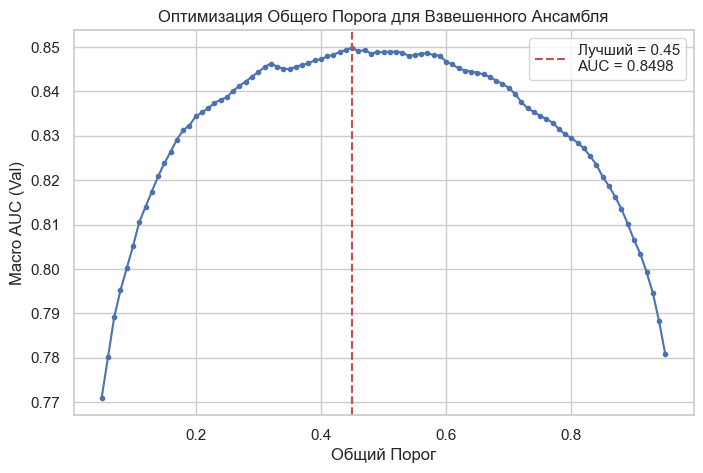


4. –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–∞ –¢–ï–°–¢–ï –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –∞–Ω—Å–∞–º–±–ª—è...

  –û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ—Å—Ç–∞ –¥–ª—è: tfidf_mlp


–û–±—â–∏–π –ø—Ä–æ–≥—Ä–µ—Å—Å:   0%|          | 0/7392 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
# --- –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π ---

def get_bert_predictions_from_trainer(model_path, hf_dataset, device, model_key_for_config, default_bert_batch_size, num_workers):
    """–ü–æ–ª—É—á–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –æ—Ç BERT-–ø–æ–¥–æ–±–Ω–æ–π –º–æ–¥–µ–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º Trainer."""
    _compute_metrics_fn = globals().get('compute_metrics', None)
    
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    
    # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —É–Ω–∏–∫–∞–ª—å–Ω–æ–≥–æ –∏–º–µ–Ω–∏ –¥–ª—è –≤—Ä–µ–º–µ–Ω–Ω–æ–π –ø–∞–ø–∫–∏
    safe_model_key_str = str(model_key_for_config).replace('/', '_')
    temp_output_dir = f"./temp_predict_dir_{safe_model_key_str}_{np.random.randint(100000)}"

    trainer_args = TrainingArguments(
        output_dir=temp_output_dir,
        per_device_eval_batch_size=globals().get(str(model_key_for_config).upper() + '_BATCH_SIZE', default_bert_batch_size) * 2,
        report_to="none",
        dataloader_num_workers=num_workers,
        disable_tqdm=True,
        logging_steps=1_000_000,
        eval_strategy="no", 
    )
    trainer = Trainer(model=model, args=trainer_args, compute_metrics=_compute_metrics_fn)
    
    predictions_output = trainer.predict(hf_dataset)
    probas = 1 / (1 + np.exp(-predictions_output.predictions))
    
    if os.path.exists(temp_output_dir):
        shutil.rmtree(temp_output_dir)
        
    del model, trainer_args, trainer, predictions_output
    return probas

def get_pytorch_model_predictions(model_instance, dataloader, device, model_type_hint):
    """–ü–æ–ª—É—á–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –æ—Ç –æ–±—ã—á–Ω–æ–π PyTorch –º–æ–¥–µ–ª–∏ (MLP, RNN, CNN)."""
    model_instance.eval()
    all_probas_list = []
    with torch.no_grad():
        for batch_data in tqdm(dataloader, desc=f"Infer: {model_instance.__class__.__name__}", leave=False):
            if model_type_hint == 'rnn':
                sequences, _, lengths = batch_data
                outputs = model_instance(sequences.to(device), lengths)
            elif model_type_hint == 'cnn':
                sequences, _, _ = batch_data
                outputs = model_instance(sequences.to(device))
            else:  # 'mlp'
                features, _ = batch_data
                outputs = model_instance(features.to(device))
            all_probas_list.append(torch.sigmoid(outputs).cpu().numpy())
    return np.concatenate(all_probas_list, axis=0)

MODELS_FOR_ENSEMBLE = ['tfidf_mlp']
# –í–æ–∑–º–æ–∂–Ω—ã–µ –∫–ª—é—á–∏: "tfidf_mlp", "w2v_lstm", "cnn_emb", "rnn_emb",
# "bert_tiny", "w2v_lstm_augmented", "hybrid_tfidf_bert_mlp", "berta_classifier_v1", "berta_classifier_v2"

ensemble_name_suffix = "_".join(sorted(MODELS_FOR_ENSEMBLE)) + "_WEIGHTED_GLOBAL_THR"
SUBMISSION_FILENAME = f"submission_ensemble_{ensemble_name_suffix}.csv"

print(f"–°–æ–∑–¥–∞–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª—è –∏–∑ –º–æ–¥–µ–ª–µ–π: {MODELS_FOR_ENSEMBLE}")
print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º–æ–µ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {device}") # 'device' –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –æ–ø—Ä–µ–¥–µ–ª–µ–Ω –≥–ª–æ–±–∞–ª—å–Ω–æ

# --- –®–∞–≥ 1: –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π) –Ω–∞ –í–ê–õ–ò–î–ê–¶–ò–ò –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ ---
print("\n1. –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–∞ –í–ê–õ–ò–î–ê–¶–ò–ò –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –∞–Ω—Å–∞–º–±–ª—è...")
all_val_probas_list = []

if 'y_val_final' not in globals(): raise NameError("y_val_final (–º–µ—Ç–∫–∏ –≤–∞–ª–∏–¥–∞—Ü–∏–∏) –Ω–µ –Ω–∞–π–¥–µ–Ω!")
val_targets_np = y_val_final
val_targets_for_auc_tensor = torch.from_numpy(val_targets_np).float()
print(f"–†–∞–∑–º–µ—Ä –æ–∂–∏–¥–∞–µ–º—ã—Ö –º–µ—Ç–æ–∫ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (y_val_final): {val_targets_np.shape}")

for model_key in MODELS_FOR_ENSEMBLE:
    print(f"\n  –û–±—Ä–∞–±–æ—Ç–∫–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –¥–ª—è: {model_key}")
    model_path = MODEL_PATHS[model_key]
    if not os.path.exists(model_path):
         raise FileNotFoundError(f"–§–∞–π–ª –∏–ª–∏ –ø–∞–ø–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–µ –Ω–∞–π–¥–µ–Ω—ã: {model_path} –¥–ª—è {model_key}")
    
    current_val_probas_np = None

    if model_key in ["bert_tiny", "berta_classifier_v1", "berta_classifier_v2"]: # BERT-–ø–æ–¥–æ–±–Ω—ã–µ –º–æ–¥–µ–ª–∏
        _current_hf_val_dataset = None
        if model_key == "bert_tiny":
            if 'tokenized_val_dataset' not in globals(): raise NameError("tokenized_val_dataset –¥–ª—è bert_tiny –Ω–µ –Ω–∞–π–¥–µ–Ω!")
            _current_hf_val_dataset = tokenized_val_dataset
        elif model_key == "berta_classifier_v1":
            if 'tokenized_val_dataset_berta_v1' in globals():
                 _current_hf_val_dataset = tokenized_val_dataset_berta_v1
            elif 'tokenized_val_dataset_berta' in globals():
                 _current_hf_val_dataset = tokenized_val_dataset_berta
            else:
                raise NameError(f"tokenized_val_dataset_berta (–∏–ª–∏ _v2) –¥–ª—è {model_key} –Ω–µ –Ω–∞–π–¥–µ–Ω!")
        elif model_key == "berta_classifier_v2":
            if 'tokenized_val_dataset_berta_v2' not in globals():
                raise NameError(f"tokenized_val_dataset_berta_v2 –¥–ª—è {model_key} –Ω–µ –Ω–∞–π–¥–µ–Ω!")
            _current_hf_val_dataset = tokenized_val_dataset_berta_v2
            
            # model_path –±—É–¥–µ—Ç MODEL_PATHS["berta_classifier_v2"]
            current_val_probas_np = get_bert_predictions_from_trainer(
                model_path, 
                _current_hf_val_dataset, 
                device, 
                model_key, # –ü–µ—Ä–µ–¥–∞–µ–º —Å–∞–º –∫–ª—é—á
                globals().get('BERTA_V2_BATCH_SIZE_PER_DEVICE', globals().get('BERT_FEATURE_EXTRACTOR_BATCH_SIZE', 16)), # –ò—Å–ø–æ–ª—å–∑—É–µ–º —Å–ø–µ—Ü–∏—Ñ–∏—á–Ω—ã–π –±–∞—Ç—á –∏–ª–∏ –¥–µ—Ñ–æ–ª—Ç
                NUM_WORKERS_ENSEMBLE_TEST
            )
        
        current_val_probas_np = get_bert_predictions_from_trainer(
            model_path, _current_hf_val_dataset, device, model_key, 
            globals().get('BERT_BATCH_SIZE', 16), NUM_WORKERS_ENSEMBLE_TEST
        )
    else: # –î—Ä—É–≥–∏–µ PyTorch –º–æ–¥–µ–ª–∏ (MLP, LSTM, CNN, Hybrid)
        model_instance = None
        current_val_loader = None
        model_type_hint = '' # 'mlp', 'rnn', 'cnn'

        # –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ –≤—Å–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ (val_loader_tfidf, INPUT_DIM –∏ —Ç.–¥.) –æ–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –≥–ª–æ–±–∞–ª—å–Ω–æ
        if model_key == "tfidf_mlp":
            if 'val_loader_tfidf' not in globals(): raise NameError("val_loader_tfidf –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_loader_tfidf
            model_instance = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        elif model_key == "w2v_lstm":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_seq_loader
            model_instance = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'rnn'
        elif model_key == "cnn_emb":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_seq_loader
            model_instance = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'cnn'
        elif model_key == "rnn_emb":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_seq_loader
            model_instance = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, RNN_TE_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'rnn'
        elif model_key == "w2v_lstm_augmented":
            if 'val_seq_loader_for_aug_model' not in globals(): raise NameError("val_seq_loader_for_aug_model –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_seq_loader_for_aug_model
            model_instance = LSTMClassifier(VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM, LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG).to(device)
            model_type_hint = 'rnn'
        elif model_key == "hybrid_tfidf_bert_mlp":
            if 'val_loader_hybrid' not in globals(): raise NameError("val_loader_hybrid –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_val_loader = val_loader_hybrid
            model_instance = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        else:
            raise ValueError(f"–õ–æ–≥–∏–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏ –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏ {model_key} –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∞.")

        model_instance.load_state_dict(torch.load(model_path, map_location=device))
        current_val_probas_np = get_pytorch_model_predictions(model_instance, current_val_loader, device, model_type_hint)
        del model_instance

    if current_val_probas_np is None:
        raise RuntimeError(f"–ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å val_preds_proba –¥–ª—è {model_key}")
    if current_val_probas_np.shape[0] != val_targets_np.shape[0]:
        raise ValueError(f"–†–∞–∑–º–µ—Ä val_preds_proba ({current_val_probas_np.shape[0]}) –¥–ª—è {model_key} –Ω–µ —Å–æ–≤–ø–∞–¥–∞–µ—Ç —Å val_targets ({val_targets_np.shape[0]})")
    
    all_val_probas_list.append(current_val_probas_np)
    print(f"  –í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è {model_key} –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –ø–æ–ª—É—á–µ–Ω—ã: {current_val_probas_np.shape}")
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

if len(all_val_probas_list) != len(MODELS_FOR_ENSEMBLE):
    raise RuntimeError("–ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è –í–°–ï–• –º–æ–¥–µ–ª–µ–π –∞–Ω—Å–∞–º–±–ª—è –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏.")
val_probas_stack_np = np.array(all_val_probas_list)

# --- –®–∞–≥ 2: –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –≤–µ—Å–æ–≤ –∞–Ω—Å–∞–º–±–ª—è –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ ---
print("\n2. –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –≤–µ—Å–æ–≤ –∞–Ω—Å–∞–º–±–ª—è –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏...")
# calculate_auc –¥–æ–ª–∂–Ω–∞ –±—ã—Ç—å –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∞ –≥–ª–æ–±–∞–ª—å–Ω–æ
def roc_auc_for_weighted_ensemble(weights, probas_stack, targets_tensor_for_auc, global_threshold=0.5):
    weighted_probas = np.tensordot(np.array(weights), probas_stack, axes=([0],[0]))
    # –ü—Ä–∏ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≤–µ—Å–æ–≤, –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –Ω–∞–ø—Ä—è–º—É—é –∏–ª–∏ –±–∏–Ω–∞—Ä–∏–∑–æ–≤–∞–Ω–Ω—ã–µ —Å —Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–º –ø–æ—Ä–æ–≥–æ–º.
    # –î–ª—è —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ AUC –ª—É—á—à–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏, –Ω–æ –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≤–µ—Å–æ–≤ —Å –ø–æ—Ä–æ–≥–æ–º - –±–∏–Ω–∞—Ä–∏–∑–æ–≤–∞–Ω–Ω—ã–µ.
    # –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–π –∫–æ–¥ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª –±–∏–Ω–∞—Ä–∏–∑–æ–≤–∞–Ω–Ω—ã–µ.
    preds_binary = (weighted_probas >= global_threshold).astype(int)
    auc_score = calculate_auc(targets_tensor_for_auc, torch.from_numpy(preds_binary).float())
    return -auc_score # –ú–∏–Ω–∏–º–∏–∑–∏—Ä—É–µ–º –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–π AUC

num_models_in_ensemble = len(MODELS_FOR_ENSEMBLE)
initial_weights = np.array([1.0 / num_models_in_ensemble] * num_models_in_ensemble)
bounds_weights = [(0.0, 1.0)] * num_models_in_ensemble # –í–µ—Å–∞ –æ—Ç 0 –¥–æ 1
constraints_weights = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}) # –°—É–º–º–∞ –≤–µ—Å–æ–≤ —Ä–∞–≤–Ω–∞ 1

print(f"  –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≤–µ—Å–æ–≤ –¥–ª—è {num_models_in_ensemble} –º–æ–¥–µ–ª–µ–π...")
optimization_result = minimize(
    roc_auc_for_weighted_ensemble, initial_weights,
    args=(val_probas_stack_np, val_targets_for_auc_tensor, 0.5), # –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ–º —Å –ø–æ—Ä–æ–≥–æ–º 0.5
    method='SLSQP', bounds=bounds_weights, constraints=constraints_weights,
    options={'disp': False, 'ftol': 1e-7, 'maxiter': 200 + num_models_in_ensemble * 50}
)

if optimization_result.success:
    best_ensemble_weights = np.clip(optimization_result.x, 0, 1)
    if np.sum(best_ensemble_weights) < 1e-6 : # –ï—Å–ª–∏ –≤—Å–µ –≤–µ—Å–∞ –±–ª–∏–∑–∫–∏ –∫ –Ω—É–ª—é
        best_ensemble_weights = initial_weights
        print("  –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –¥–∞–ª–∞ –Ω—É–ª–µ–≤—ã–µ –≤–µ—Å–∞, –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ä–∞–≤–Ω—ã–µ –≤–µ—Å–∞.")
    else:
        best_ensemble_weights = best_ensemble_weights / np.sum(best_ensemble_weights) # –ù–æ—Ä–º–∞–ª–∏–∑—É–µ–º
    print(f"  –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –≤–µ—Å–∞ –∞–Ω—Å–∞–º–±–ª—è: {best_ensemble_weights}")
else:
    print(f"  –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –≤–µ—Å–æ–≤ –Ω–µ —É–¥–∞–ª–∞—Å—å. –ò—Å–ø–æ–ª—å–∑—É–µ–º —Ä–∞–≤–Ω—ã–µ –≤–µ—Å–∞.")
    best_ensemble_weights = initial_weights

auc_at_optimal_weights_thr05 = -roc_auc_for_weighted_ensemble(best_ensemble_weights, val_probas_stack_np, val_targets_for_auc_tensor, 0.5)
print(f"  AUC –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —Å –≤—ã–±—Ä–∞–Ω–Ω—ã–º–∏ –≤–µ—Å–∞–º–∏ (–∏ –≥–ª–æ–±. –ø–æ—Ä–æ–≥–æ–º 0.5): {auc_at_optimal_weights_thr05:.4f}")
weighted_avg_val_proba_np = np.tensordot(best_ensemble_weights, val_probas_stack_np, axes=([0],[0]))

# --- –®–∞–≥ 3: –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –û–î–ù–û–ì–û –û–ë–©–ï–ì–û –ø–æ—Ä–æ–≥–∞ –¥–ª—è –≤–∑–≤–µ—à–µ–Ω–Ω—ã—Ö –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π –∞–Ω—Å–∞–º–±–ª—è ---
print("\n3. –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –û–ë–©–ï–ì–û –ø–æ—Ä–æ–≥–∞ –¥–ª—è –≤–∑–≤–µ—à–µ–Ω–Ω—ã—Ö –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π –∞–Ω—Å–∞–º–±–ª—è...")
best_global_threshold_ensemble = 0.5
best_val_auc_for_global_threshold = -1.0
auc_by_global_threshold_ensemble = []
thresholds_to_check_global = np.arange(0.05, 0.96, 0.01) # –î–∏–∞–ø–∞–∑–æ–Ω –ø–æ—Ä–æ–≥–æ–≤

for threshold_val in tqdm(thresholds_to_check_global, desc="Optimizing Global Ensemble Threshold"):
    val_preds_binary_ensemble = (weighted_avg_val_proba_np >= threshold_val).astype(int)
    current_auc_ensemble = calculate_auc(val_targets_for_auc_tensor, torch.from_numpy(val_preds_binary_ensemble).float())
    auc_by_global_threshold_ensemble.append(current_auc_ensemble)
    if current_auc_ensemble > best_val_auc_for_global_threshold:
        best_val_auc_for_global_threshold = current_auc_ensemble
        best_global_threshold_ensemble = threshold_val

print(f"\n–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –û–ë–©–ò–ô –ø–æ—Ä–æ–≥ –¥–ª—è –∞–Ω—Å–∞–º–±–ª—è: {best_global_threshold_ensemble:.2f}")
print(f"–ò—Ç–æ–≥–æ–≤—ã–π Macro AUC –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (—Å –æ–ø—Ç. –≤–µ—Å–∞–º–∏ –∏ –æ–ø—Ç. –û–ë–©–ò–ú –ø–æ—Ä–æ–≥–æ–º): {best_val_auc_for_global_threshold:.4f}")

plt.figure(figsize=(8,5))
plt.plot(thresholds_to_check_global, auc_by_global_threshold_ensemble, marker='.')
plt.xlabel("–û–±—â–∏–π –ü–æ—Ä–æ–≥")
plt.ylabel("Macro AUC (Val)")
plt.title(f"–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –û–±—â–µ–≥–æ –ü–æ—Ä–æ–≥–∞ –¥–ª—è –í–∑–≤–µ—à–µ–Ω–Ω–æ–≥–æ –ê–Ω—Å–∞–º–±–ª—è")
plt.grid(True)
plt.axvline(best_global_threshold_ensemble, color='r', linestyle='--', label=f'–õ—É—á—à–∏–π = {best_global_threshold_ensemble:.2f}\nAUC = {best_val_auc_for_global_threshold:.4f}')
plt.legend()
plt.show()

# --- –®–∞–≥ 4: –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–∞ –¢–ï–°–¢–ï –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –∞–Ω—Å–∞–º–±–ª—è ---
print("\n4. –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –Ω–∞ –¢–ï–°–¢–ï –æ—Ç –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –∞–Ω—Å–∞–º–±–ª—è...")
all_test_probas_list = []
# DATA_PATH –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –æ–ø—Ä–µ–¥–µ–ª–µ–Ω –≥–ª–æ–±–∞–ª—å–Ω–æ
test_df_orig = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
test_ids = test_df_orig['id'].tolist()
test_df_processed = test_df_orig.copy() # –ö–æ–ø–∏—è –¥–ª—è –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤

for model_key in MODELS_FOR_ENSEMBLE:
    print(f"\n  –û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ—Å—Ç–∞ –¥–ª—è: {model_key}")
    model_path = MODEL_PATHS[model_key]
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"–§–∞–π–ª –∏–ª–∏ –ø–∞–ø–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–µ –Ω–∞–π–¥–µ–Ω—ã: {model_path} –¥–ª—è {model_key}")
    
    current_test_probas_np = None

    if model_key in ["bert_tiny", "berta_classifier_v1"]:
        _current_tokenizer_test = AutoTokenizer.from_pretrained(model_path) # –¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –∏–∑ –ø–∞–ø–∫–∏ –º–æ–¥–µ–ª–∏
        
        if 'text_cleaned_bert' not in test_df_processed.columns: # clean_text_for_bert –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –≥–ª–æ–±–∞–ª—å–Ω—ã–º
            test_df_processed['text_cleaned_bert'] = test_df_processed['text'].progress_apply(clean_text_for_bert)
        
        _max_len_current_bert = BERT_MAX_LEN if model_key == "bert_tiny" else BERT_MAX_LEN_BERTA # –ì–ª–æ–±–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ
        
        test_texts_for_bert = test_df_processed['text_cleaned_bert'].tolist()
        hg_test_dataset_current_bert = HFDataset.from_dict({'text': test_texts_for_bert})
        
        def tokenize_fn_for_test(examples): # –õ–æ–∫–∞–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–º—ã–∫–∞–Ω–∏—è _current_tokenizer_test –∏ _max_len_current_bert
            return _current_tokenizer_test(examples['text'], truncation=True, padding="max_length", max_length=_max_len_current_bert)
        
        tokenized_test_dataset_current_bert = hg_test_dataset_current_bert.map(
            tokenize_fn_for_test, batched=True, remove_columns=['text'], desc=f"Tokenizing Test for {model_key}"
        )
        tokenized_test_dataset_current_bert.set_format("torch")

        current_test_probas_np = get_bert_predictions_from_trainer(
            model_path, tokenized_test_dataset_current_bert, device, model_key,
            globals().get('BERT_BATCH_SIZE', 16), NUM_WORKERS_ENSEMBLE_TEST
        )
        del _current_tokenizer_test, tokenized_test_dataset_current_bert, hg_test_dataset_current_bert
    elif model_key == "berta_classifier_v2": # <--- –£–±–µ–¥–∏—Ç–µ—Å—å, —á—Ç–æ –∫–ª—é—á –∑–¥–µ—Å—å —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –≤–∞—à–µ–º—É MODEL_PATHS
        # –¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤–º–µ—Å—Ç–µ —Å –º–æ–¥–µ–ª—å—é berta_classifier_v2
        _current_tokenizer_test = AutoTokenizer.from_pretrained(model_path) 
        
        if 'text_cleaned_bert' not in test_df_processed.columns:
            test_df_processed['text_cleaned_bert'] = test_df_processed['text'].progress_apply(clean_text_for_bert)
        
        # –ò—Å–ø–æ–ª—å–∑—É–µ–º BERTA_V2_MAX_LEN, –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã–π –≥–ª–æ–±–∞–ª—å–Ω–æ
        _max_len_current_bert = BERTA_V2_MAX_LEN 
        
        test_texts_for_bert = test_df_processed['text_cleaned_bert'].tolist()
        hg_test_dataset_current_bert = HFDataset.from_dict({'text': test_texts_for_bert})
        
        def tokenize_fn_for_test(examples):
            return _current_tokenizer_test(examples['text'], truncation=True, padding="max_length", max_length=_max_len_current_bert)
        
        tokenized_test_dataset_current_bert = hg_test_dataset_current_bert.map(
            tokenize_fn_for_test, batched=True, remove_columns=['text'], desc=f"Tokenizing Test for {model_key}"
        )
        tokenized_test_dataset_current_bert.set_format("torch")

        current_test_probas_np = get_bert_predictions_from_trainer(
            model_path, 
            tokenized_test_dataset_current_bert, 
            device, 
            model_key,
            globals().get('BERTA_V2_BATCH_SIZE_PER_DEVICE', globals().get('BERT_BATCH_SIZE', 16)), # –ò—Å–ø–æ–ª—å–∑—É–µ–º —Å–ø–µ—Ü–∏—Ñ–∏—á–Ω—ã–π –±–∞—Ç—á –∏–ª–∏ –¥–µ—Ñ–æ–ª—Ç
            NUM_WORKERS_ENSEMBLE_TEST
        )
        del _current_tokenizer_test, tokenized_test_dataset_current_bert, hg_test_dataset_current_bert
    
    else: # –î—Ä—É–≥–∏–µ PyTorch –º–æ–¥–µ–ª–∏
        model_instance = None
        current_test_loader = None
        model_type_hint = ''
        # –í—Å–µ —Ñ—É–Ω–∫—Ü–∏–∏ –æ—á–∏—Å—Ç–∫–∏, –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ç–æ—Ä—ã, —Å–ª–æ–≤–∞—Ä–∏ –∏ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–µ–π –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞—é—Ç—Å—è –≥–ª–æ–±–∞–ª—å–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã–º–∏

        if model_key == "tfidf_mlp":
            cleaned_col = 'text_cleaned_tfidf_test'
            if cleaned_col not in test_df_processed.columns:
                test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
            X_test_tfidf = tfidf_vectorizer.transform(test_df_processed[cleaned_col])
            test_dataset = TfidfDataset(X_test_tfidf, np.zeros((X_test_tfidf.shape[0], OUTPUT_DIM)))
            current_test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        
        elif model_key in ["w2v_lstm", "cnn_emb", "rnn_emb"]:
            # –ò—Å–ø–æ–ª—å–∑—É–µ–º –æ–±—â—É—é –æ—á–∏—Å—Ç–∫—É, –Ω–æ —Ä–∞–∑–Ω—ã–µ –º–æ–¥–µ–ª–∏
            cleaned_col = f'text_cleaned_seq_test_{model_key}'
            if cleaned_col not in test_df_processed.columns:
                 test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(clean_text_for_sequential)
            
            test_sequences = [text_to_sequence(text, word_to_idx) for text in tqdm(test_df_processed[cleaned_col], desc=f"Test Seq ({model_key})")]
            test_dataset = SequenceDataset(test_sequences, np.zeros((len(test_sequences), OUTPUT_DIM)), MAX_LEN)
            _collate_fn = collate_fn_for_w2v_lstm if 'collate_fn_for_w2v_lstm' in globals() else None
            if _collate_fn is None and model_key != "cnn_emb":
                 print(f"–ü—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏–µ: collate_fn_for_w2v_lstm –Ω–µ –Ω–∞–π–¥–µ–Ω –¥–ª—è {model_key}, –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π collate_fn.")

            current_test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, collate_fn=_collate_fn, num_workers=NUM_WORKERS_ENSEMBLE_TEST)

            if model_key == "w2v_lstm":
                model_instance = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'rnn'
            elif model_key == "cnn_emb":
                model_instance = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'cnn'
            elif model_key == "rnn_emb":
                model_instance = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, RNN_TE_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'rnn'

        elif model_key == "w2v_lstm_augmented":
            cleaned_col = 'text_cleaned_seq_test_aug'
            if cleaned_col not in test_df_processed.columns:
                test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(clean_text_for_sequential)
            
            test_sequences_aug = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(test_df_processed[cleaned_col], desc=f"Test Seq ({model_key})")]
            # MAX_LEN_AUG –∏–ª–∏ MAX_LEN? –û—Ä–∏–≥–∏–Ω–∞–ª –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª MAX_LEN. –£—Ç–æ—á–Ω–∏—Ç—å, –µ—Å–ª–∏ –µ—Å—Ç—å MAX_LEN_AUG.
            _max_len_aug = globals().get('MAX_LEN_AUG', MAX_LEN) 
            test_dataset_aug = SequenceDataset(test_sequences_aug, np.zeros((len(test_sequences_aug), OUTPUT_DIM)), _max_len_aug)
            # collate_fn_for_augmented_lstm –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –æ–ø—Ä–µ–¥–µ–ª–µ–Ω –≥–ª–æ–±–∞–ª—å–Ω–æ
            if 'collate_fn_for_augmented_lstm' not in globals(): raise NameError("collate_fn_for_augmented_lstm –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω!")
            current_test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, collate_fn=collate_fn_for_augmented_lstm, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = LSTMClassifier(VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM, LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG).to(device)
            model_type_hint = 'rnn'

        elif model_key == "hybrid_tfidf_bert_mlp":
            cleaned_col_tfidf = 'text_cleaned_tfidf_hybrid_test'
            if cleaned_col_tfidf not in test_df_processed.columns:
                test_df_processed[cleaned_col_tfidf] = test_df_processed['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
            X_test_tfidf_h = tfidf_vectorizer.transform(test_df_processed[cleaned_col_tfidf])
            
            cleaned_col_bert = 'text_cleaned_bert_hybrid_test'
            if cleaned_col_bert not in test_df_processed.columns:
                test_df_processed[cleaned_col_bert] = test_df_processed['text'].progress_apply(clean_text_for_bert)
            test_bert_texts_h = test_df_processed[cleaned_col_bert].tolist()
            
            # –ì–ª–æ–±–∞–ª—å–Ω—ã–µ: bert_feature_extractor, tokenizer_bert_features, get_bert_embeddings
            if not all(k in globals() for k in ['bert_feature_extractor', 'tokenizer_bert_features', 'get_bert_embeddings']):
                raise NameError("–ö–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –¥–ª—è –≥–∏–±—Ä–∏–¥–Ω–æ–π –º–æ–¥–µ–ª–∏ (BERT features) –Ω–µ –Ω–∞–π–¥–µ–Ω—ã.")
            X_test_bert_h_np = get_bert_embeddings(test_bert_texts_h, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_HYBRID_FEATURES, batch_size=globals().get('BERT_BATCH_SIZE',16))
            X_test_combined_h = sparse_hstack([X_test_tfidf_h, csr_matrix(X_test_bert_h_np)], format='csr')
            
            test_dataset_h = TfidfDataset(X_test_combined_h, np.zeros((X_test_combined_h.shape[0], OUTPUT_DIM)))
            current_test_loader = DataLoader(test_dataset_h, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        else:
            raise ValueError(f"–õ–æ–≥–∏–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏ –¥–ª—è –¢–ï–°–¢–ê –º–æ–¥–µ–ª–∏ {model_key} –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∞.")

        model_instance.load_state_dict(torch.load(model_path, map_location=device))
        current_test_probas_np = get_pytorch_model_predictions(model_instance, current_test_loader, device, model_type_hint)
        del model_instance

    if current_test_probas_np is None:
        raise RuntimeError(f"–ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å test_preds_proba –¥–ª—è {model_key}")
    if current_test_probas_np.shape[0] != len(test_ids):
        raise ValueError(f"–†–∞–∑–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π —Ç–µ—Å—Ç–∞ ({current_test_probas_np.shape[0]}) –¥–ª—è {model_key} –Ω–µ —Å–æ–≤–ø–∞–¥–∞–µ—Ç —Å test_ids ({len(test_ids)})!")
    
    all_test_probas_list.append(current_test_probas_np)
    print(f"  –í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è {model_key} –Ω–∞ —Ç–µ—Å—Ç–µ –ø–æ–ª—É—á–µ–Ω—ã: {current_test_probas_np.shape}")
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

if len(all_test_probas_list) != len(MODELS_FOR_ENSEMBLE):
    raise RuntimeError("–ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è –í–°–ï–• –º–æ–¥–µ–ª–µ–π –∞–Ω—Å–∞–º–±–ª—è –Ω–∞ —Ç–µ—Å—Ç–µ.")
test_probas_stack_np = np.array(all_test_probas_list)

# --- –®–∞–≥ 5: –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –≤–µ—Å–æ–≤ –∫ —Ç–µ—Å—Ç–æ–≤—ã–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º ---
print("\n5. –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –≤–µ—Å–æ–≤ –∫ —Ç–µ—Å—Ç–æ–≤—ã–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º...")
weighted_avg_test_proba_np = np.tensordot(best_ensemble_weights, test_probas_stack_np, axes=([0],[0]))
print(f"–§–æ—Ä–º–∞ –≤–∑–≤–µ—à–µ–Ω–Ω—ã—Ö —Ç–µ—Å—Ç–æ–≤—ã—Ö –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π: {weighted_avg_test_proba_np.shape}")

# --- –®–∞–≥ 6: –§–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ —Å–∞–±–º–∏—Ç–∞ —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º –û–ë–©–ò–ú –ø–æ—Ä–æ–≥–æ–º ---
print(f"\n6. –§–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ —Ñ–∞–π–ª–∞ —Å–∞–±–º–∏—Ç–∞ –¥–ª—è –∞–Ω—Å–∞–º–±–ª—è —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º–∏ –≤–µ—Å–∞–º–∏ –∏ –û–ë–©–ò–ú –ø–æ—Ä–æ–≥–æ–º {best_global_threshold_ensemble:.2f}...")
final_preds_binary_ensemble_test = (weighted_avg_test_proba_np >= best_global_threshold_ensemble).astype(int)
pred_strings_ensemble_test = [" ".join(map(str, row)) for row in final_preds_binary_ensemble_test]
submission_df_final_ensemble = pd.DataFrame({'id': test_ids, 'labels': pred_strings_ensemble_test})

if submission_df_final_ensemble.shape[0] == sample_submission_df.shape[0] and \
   list(submission_df_final_ensemble.columns) == list(sample_submission_df.columns):
    print(f"–§–æ—Ä–º–∞—Ç —Å–∞–±–º–∏—Ç–∞ (–≤–∑–≤–µ—à–µ–Ω–Ω—ã–π –∞–Ω—Å–∞–º–±–ª—å —Å –æ–±—â–∏–º –æ–ø—Ç. –ø–æ—Ä–æ–≥–æ–º) –∫–æ—Ä—Ä–µ–∫—Ç–µ–Ω. –†–∞–∑–º–µ—Ä: {submission_df_final_ensemble.shape}")
    submission_df_final_ensemble.to_csv(SUBMISSION_FILENAME, index=False)
    print(f"–§–∞–π–ª —Å–∞–±–º–∏—Ç–∞ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –∫–∞–∫: {SUBMISSION_FILENAME}")
else:
    print("–û—à–∏–±–∫–∞: –§–æ—Ä–º–∞—Ç –∏–ª–∏ —Ä–∞–∑–º–µ—Ä —Å–∞–±–º–∏—Ç–∞ (–≤–∑–≤–µ—à–µ–Ω–Ω—ã–π –∞–Ω—Å–∞–º–±–ª—å) –Ω–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç sample_submission!")

print("\n–ü—Ä–æ—Ü–µ—Å—Å –∞–Ω—Å–∞–º–±–ª–∏—Ä–æ–≤–∞–Ω–∏—è (—Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –≤–µ—Å–æ–≤ –∏ –û–ë–©–ï–ì–û –ø–æ—Ä–æ–≥–∞) –∏ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ —Å–∞–±–º–∏—Ç–∞ –∑–∞–≤–µ—Ä—à–µ–Ω.")

–ù–µ —É –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π —É—Å–ø–µ–ª –¥–æ–±–∞–≤–∏—Ç—å –≤–∑–≤–µ—à–∏–≤–∞–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤, –Ω–µ –≤—Å–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –¥–ª—è –∞–Ω—Å–∞–º–±–ª–µ–π –ø–æ–ø—Ä–æ–±–æ–≤–∞–ª, –∞ —Ç–∞–∫ –¥–æ–≤–æ–ª—å–Ω–æ –º–Ω–æ–≥–æ –≤—Å–µ–≥–æ —Å–¥–µ–ª–∞–ª \
–ì—Ä—É—Å—Ç–Ω–æ —á—Ç–æ –º–æ–¥–µ–ª—å–∫–∞ –Ω–∞ 5 –º–∏–Ω—É—Ç –¥–æ–ª—å—à–µ –æ–±—É—á–∞–ª–∞—Å—å, –∞ —Ç–∞–∫ –±—ã –Ω–∞ –ø—Ä–∞–π–≤–∞—Ç–µ –∏ –ø–∞–±–ª–∏–∫–µ 2 –º–µ—Å—Ç–æ –∑–∞–Ω—è–ª \
–µ—â—ë –±—ã–ª–æ –±—ã –∫–ª–∞—Å—Å–Ω–æ –ø–æ—Å–ª–µ–¥–Ω–∏–π –±–ª–æ–∫ –∫–æ–¥–∞ –≤ —Ñ—É–Ω–∫—Ü–∏—é –æ–±–µ—Ä–Ω—É—Ç—å, –Ω–æ –¥–ª—è –ø—Ä–æ—Ç–æ—Ç–∏–ø–∏—Ä–æ–≤–∞–Ω–∏—è –∏ —ç—Ç–æ–≥–æ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ \
–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: –∞–Ω—Å–∞–º–±–ª—å tfidf_mlp + w2v_lstm + berta_classifier_v2